## Analisis Anomali Detection Motor XX

### 1. Data Loading

In [32]:
# Library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers


import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [33]:
# Loading Data
df = pd.read_csv("yaskawa_train.csv")

# Konversi waktu ke dalam format waktu seconds
df['Time'] = pd.to_timedelta(df['Time'])
df['Time'] = df['Time'].dt.total_seconds()
df.sort_index()

df.tail(100)

,Time,Frequency Reference,Output Frequency,Output Current,Output Power,Output Voltage,Minor Fault,Major Fault,During Run,Fault Output,Output Frequency After Soft-start,Over Run Error,Timeout,Fin Temperature,Cooling Fin Temperature,Cooling Fan Operation Time,Electric Power (kWh)
2303,1147.973,48.07,48.08,80.73,45.1,370.4,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,36.0,1388.0,650.0
2304,1148.564,48.08,48.08,84.30,45.1,370.5,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,36.0,1388.0,650.0
2305,1149.141,48.07,48.07,82.27,40.5,370.3,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,36.0,1388.0,650.0
2306,1149.736,48.08,48.08,81.52,45.0,370.4,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,36.0,1388.0,650.0
2307,1150.331,48.08,48.08,83.02,43.3,370.4,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,36.0,1388.0,650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2398,1204.510,48.08,48.08,82.45,39.1,370.3,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,36.0,1388.0,650.0
2399,1205.245,48.08,48.08,80.60,43.6,370.5,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,36.0,1388.0,650.0
2400,1205.950,48.08,48.08,84.52,44.2,370.6,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,36.0,1388.0,650.0
2401,1206.561,48.08,48.08,80.20,45.1,370.3,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,36.0,1388.0,650.0


In [34]:
# Kolom baru
df['RPM Ref'] = df['Frequency Reference'] * 120 / 2
df['RPM Out'] = df['Output Frequency'] * 120 / 2
df['Power Factor'] = (df['Output Power'] * 1000) / (np.sqrt(3) * df['Output Voltage'] * df['Output Current'])
df['Slip (%)'] = (abs(df['RPM Out'] - df['RPM Ref']) / df['RPM Out']) * 100
df['Daya Semu (kVA)'] = (np.sqrt(3) * df['Output Voltage'] * df['Output Current']) / 1000
df['Efficiency (%)'] = 93.5
df['Daya Output Motor (kW)'] = (np.sqrt(3) * df['Output Voltage'] * df['Output Current'] * df['Efficiency (%)'] / 100 * df['Power Factor']) / 1000
df['Torque (Nm)'] = 5250*746*1.356/df['RPM Out']
df.head(100)

,Time,Frequency Reference,Output Frequency,Output Current,Output Power,Output Voltage,Minor Fault,Major Fault,During Run,Fault Output,...,Cooling Fan Operation Time,Electric Power (kWh),RPM Ref,RPM Out,Power Factor,Slip (%),Daya Semu (kVA),Efficiency (%),Daya Output Motor (kW),Torque (Nm)
0,0.182,48.08,48.08,84.12,45.4,370.5,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.841023,0.000000,53.981892,93.5,42.4490,1840.950499
1,0.323,48.09,48.08,82.67,44.3,370.5,0.0,0.0,1.0,0.0,...,1388.0,636.0,2885.4,2884.8,0.835039,0.020799,53.051391,93.5,41.4205,1840.950499
2,0.464,48.08,48.08,84.08,45.4,370.5,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.841423,0.000000,53.956223,93.5,42.4490,1840.950499
3,0.612,48.08,48.08,86.50,45.1,370.6,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.812259,0.000000,55.524180,93.5,42.1685,1840.950499
4,0.756,48.08,48.08,80.95,44.5,370.5,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.856632,0.000000,51.947625,93.5,41.6075,1840.950499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,15.936,48.07,48.08,82.49,40.5,370.3,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.2,2884.8,0.765490,0.020799,52.907305,93.5,37.8675,1840.950499
96,16.124,48.08,48.08,80.51,43.3,370.3,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.838540,0.000000,51.637376,93.5,40.4855,1840.950499
97,16.317,48.08,48.08,80.38,45.0,370.4,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.872636,0.000000,51.567919,93.5,42.0750,1840.950499
98,16.502,48.08,48.08,80.82,45.1,370.5,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.869579,0.000000,51.864200,93.5,42.1685,1840.950499


In [35]:
# Cek apakah ada duplikasi
print(f"Jumlah data duplikat: {df.duplicated().sum()}")

# Hapus data duplikat
df = df.drop_duplicates()

Jumlah data duplikat: 0


In [36]:
# Cek apakah ada data kosong
print(f"Jumlah data kosong: {df.isnull().sum()}")

Jumlah data kosong: Time                                 0
Frequency Reference                  0
Output Frequency                     0
Output Current                       0
Output Power                         0
Output Voltage                       0
Minor Fault                          0
Major Fault                          0
During Run                           0
Fault Output                         0
Output Frequency After Soft-start    0
Over Run Error                       0
Timeout                              0
Fin Temperature                      0
Cooling Fin Temperature              0
Cooling Fan Operation Time           0
Electric Power (kWh)                 0
RPM Ref                              0
RPM Out                              0
Power Factor                         0
Slip (%)                             0
Daya Semu (kVA)                      0
Efficiency (%)                       0
Daya Output Motor (kW)               0
Torque (Nm)                          0
dtype

In [37]:
baris_kosong = df[df.isnull().any(axis=1)]

baris_kosong

,Time,Frequency Reference,Output Frequency,Output Current,Output Power,Output Voltage,Minor Fault,Major Fault,During Run,Fault Output,...,Cooling Fan Operation Time,Electric Power (kWh),RPM Ref,RPM Out,Power Factor,Slip (%),Daya Semu (kVA),Efficiency (%),Daya Output Motor (kW),Torque (Nm)


In [38]:
train = df.dropna()
train

,Time,Frequency Reference,Output Frequency,Output Current,Output Power,Output Voltage,Minor Fault,Major Fault,During Run,Fault Output,...,Cooling Fan Operation Time,Electric Power (kWh),RPM Ref,RPM Out,Power Factor,Slip (%),Daya Semu (kVA),Efficiency (%),Daya Output Motor (kW),Torque (Nm)
0,0.182,48.08,48.08,84.12,45.4,370.5,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.841023,0.000000,53.981892,93.5,42.4490,1840.950499
1,0.323,48.09,48.08,82.67,44.3,370.5,0.0,0.0,1.0,0.0,...,1388.0,636.0,2885.4,2884.8,0.835039,0.020799,53.051391,93.5,41.4205,1840.950499
2,0.464,48.08,48.08,84.08,45.4,370.5,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.841423,0.000000,53.956223,93.5,42.4490,1840.950499
3,0.612,48.08,48.08,86.50,45.1,370.6,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.812259,0.000000,55.524180,93.5,42.1685,1840.950499
4,0.756,48.08,48.08,80.95,44.5,370.5,0.0,0.0,1.0,0.0,...,1388.0,636.0,2884.8,2884.8,0.856632,0.000000,51.947625,93.5,41.6075,1840.950499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2398,1204.510,48.08,48.08,82.45,39.1,370.3,0.0,0.0,1.0,0.0,...,1388.0,650.0,2884.8,2884.8,0.739387,0.000000,52.881650,93.5,36.5585,1840.950499
2399,1205.245,48.08,48.08,80.60,43.6,370.5,0.0,0.0,1.0,0.0,...,1388.0,650.0,2884.8,2884.8,0.842952,0.000000,51.723021,93.5,40.7660,1840.950499
2400,1205.950,48.08,48.08,84.52,44.2,370.6,0.0,0.0,1.0,0.0,...,1388.0,650.0,2884.8,2884.8,0.814698,0.000000,54.253221,93.5,41.3270,1840.950499
2401,1206.561,48.08,48.08,80.20,45.1,370.3,0.0,0.0,1.0,0.0,...,1388.0,650.0,2884.8,2884.8,0.876774,0.000000,51.438549,93.5,42.1685,1840.950499


In [39]:
train.describe()

,Time,Frequency Reference,Output Frequency,Output Current,Output Power,Output Voltage,Minor Fault,Major Fault,During Run,Fault Output,...,Cooling Fan Operation Time,Electric Power (kWh),RPM Ref,RPM Out,Power Factor,Slip (%),Daya Semu (kVA),Efficiency (%),Daya Output Motor (kW),Torque (Nm)
count,2403.000000,2403.000000,2403.000000,2403.000000,2403.000000,2403.000000,2403.0,2403.0,2403.0,2403.0,...,2403.0,2403.000000,2403.000000,2403.000000,2403.000000,2403.000000,2403.000000,2403.0,2403.000000,2403.000000
mean,513.819447,48.079005,48.078960,82.627191,43.609155,370.421057,0.0,0.0,1.0,0.0,...,1388.0,642.024136,2884.740325,2884.737578,0.822810,0.003557,53.012797,93.5,40.774560,1840.990348
std,370.394953,0.005094,0.004071,1.927013,2.131757,0.082110,0.0,0.0,0.0,0.0,...,0.0,4.491207,0.305625,0.244231,0.039678,0.007833,1.243973,0.0,1.993193,0.155874
min,0.182000,48.060000,48.070000,79.010000,36.500000,370.200000,0.0,0.0,1.0,0.0,...,1388.0,636.000000,2883.600000,2884.200000,0.689886,0.000000,50.675308,93.5,34.127500,1840.567686
25%,168.730000,48.080000,48.080000,81.000000,42.500000,370.400000,0.0,0.0,1.0,0.0,...,1388.0,638.000000,2884.800000,2884.800000,0.804036,0.000000,51.951652,93.5,39.737500,1840.950499
50%,470.054000,48.080000,48.080000,82.450000,44.300000,370.400000,0.0,0.0,1.0,0.0,...,1388.0,642.000000,2884.800000,2884.800000,0.830042,0.000000,52.895931,93.5,41.420500,1840.950499
75%,835.915500,48.080000,48.080000,84.260000,45.100000,370.500000,0.0,0.0,1.0,0.0,...,1388.0,646.000000,2884.800000,2884.800000,0.850749,0.000000,54.057139,93.5,42.168500,1840.950499
max,1207.247000,48.090000,48.090000,86.860000,47.400000,370.600000,0.0,0.0,1.0,0.0,...,1388.0,650.000000,2885.400000,2885.400000,0.894492,0.020803,55.740218,93.5,44.319000,1841.333472


### 2. Exploratory Data Analysis

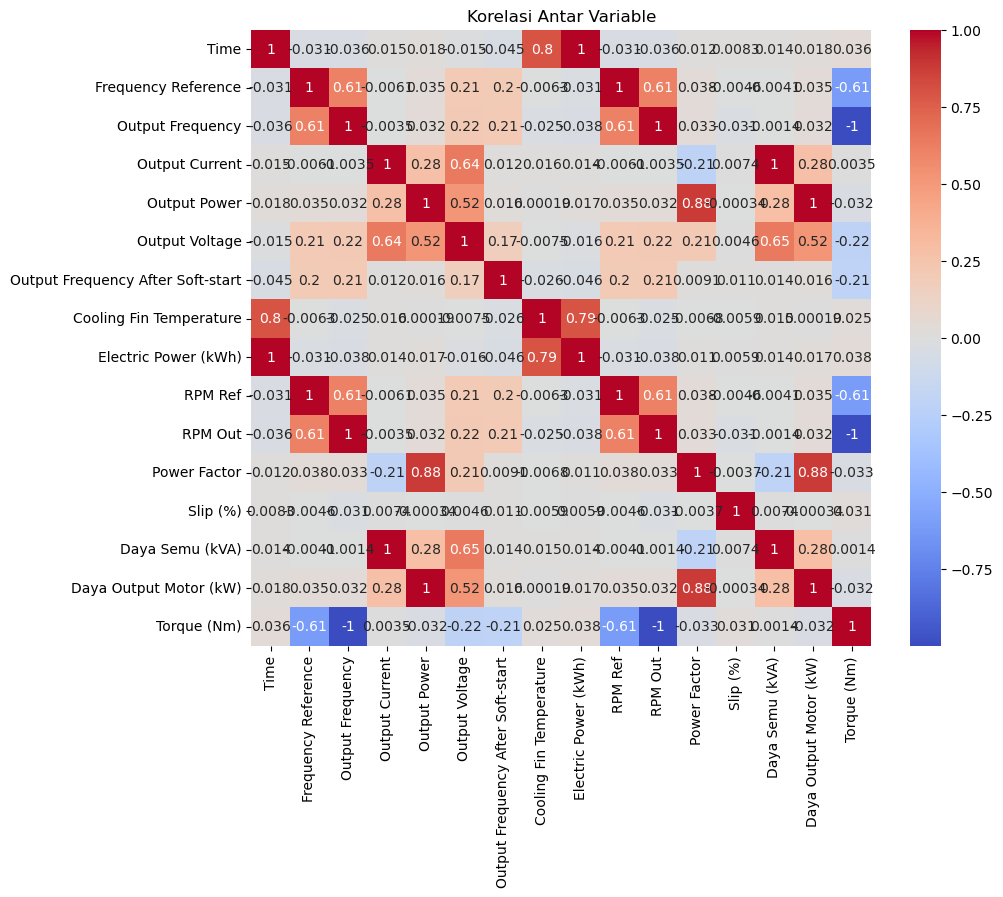

In [40]:
# Menghapus kolom yang memiliki nilai konstan dan yang hanya berisi 0 dan 1
filtered_cols = [col for col in train.columns
                 if train[col].nunique() > 1 and not set(train[col].unique()).issubset({0, 1})]

filtered_train = train[filtered_cols]

# Menghitung korelasi dan menampilkan heatmap
corr = filtered_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Variable')
plt.show()

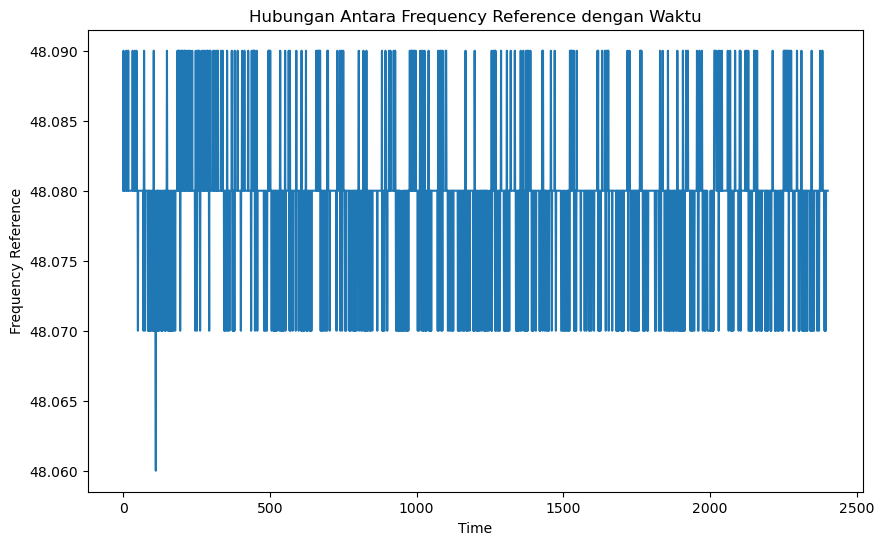

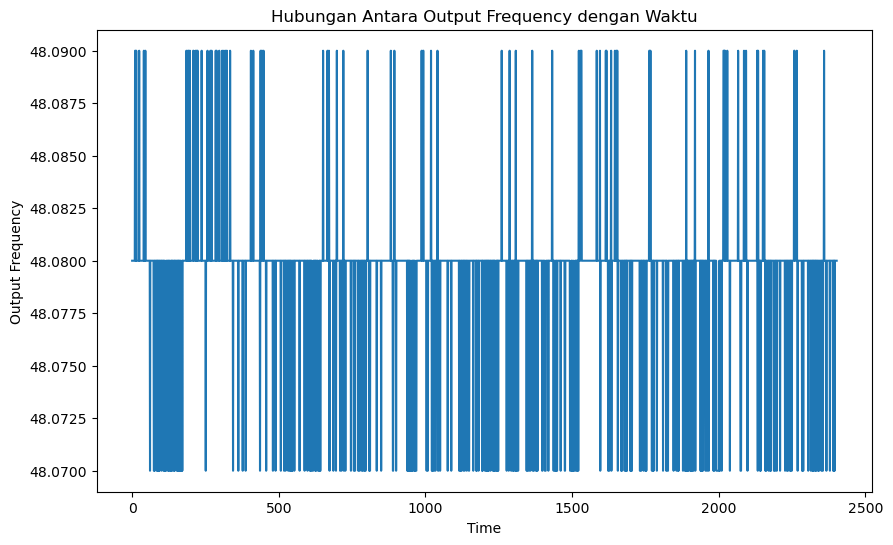

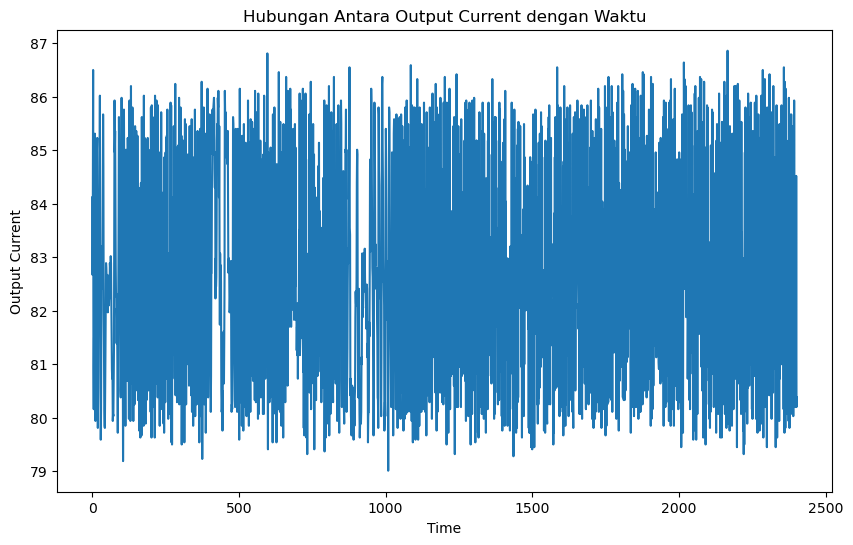

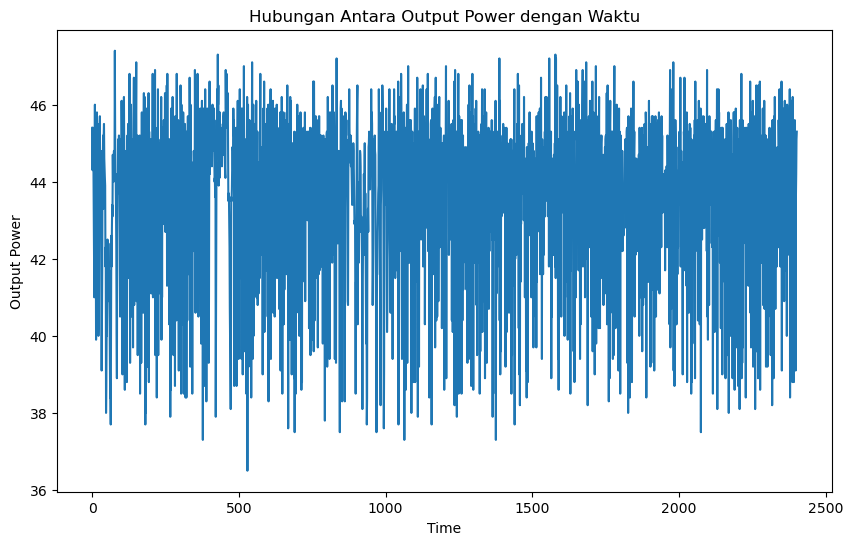

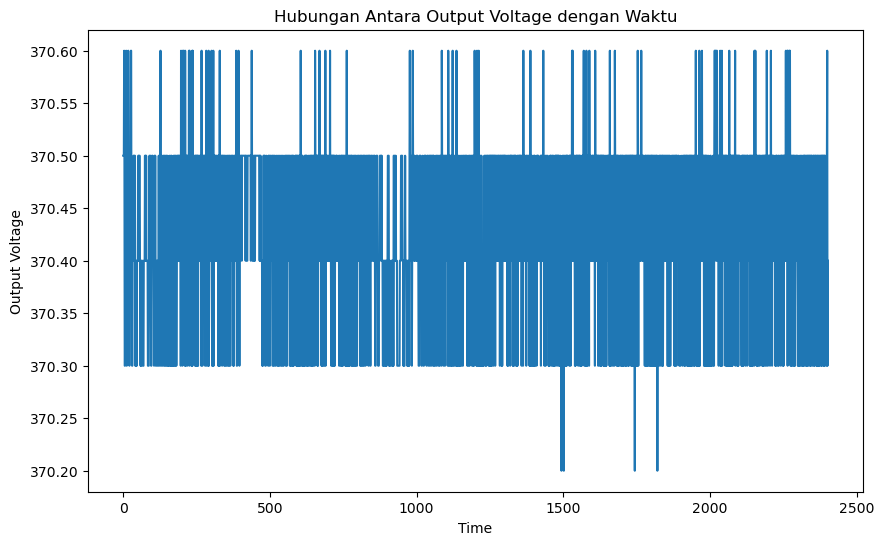

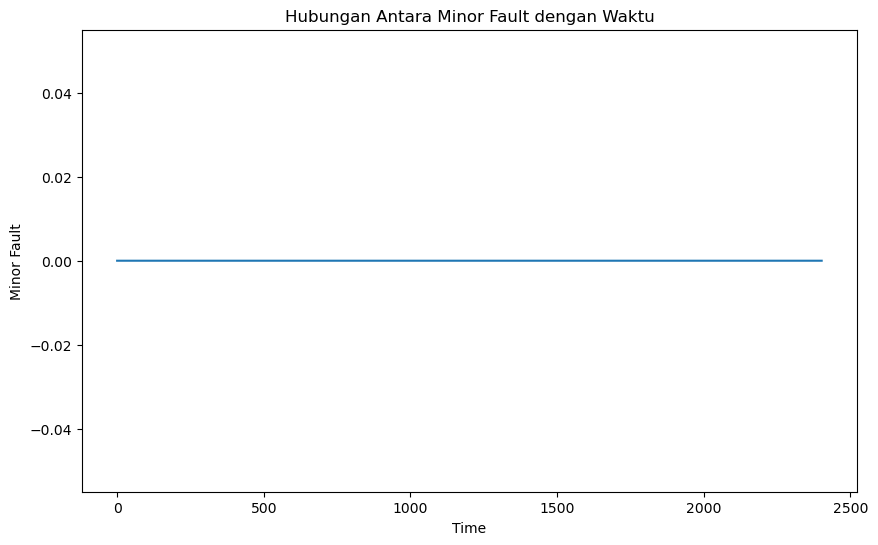

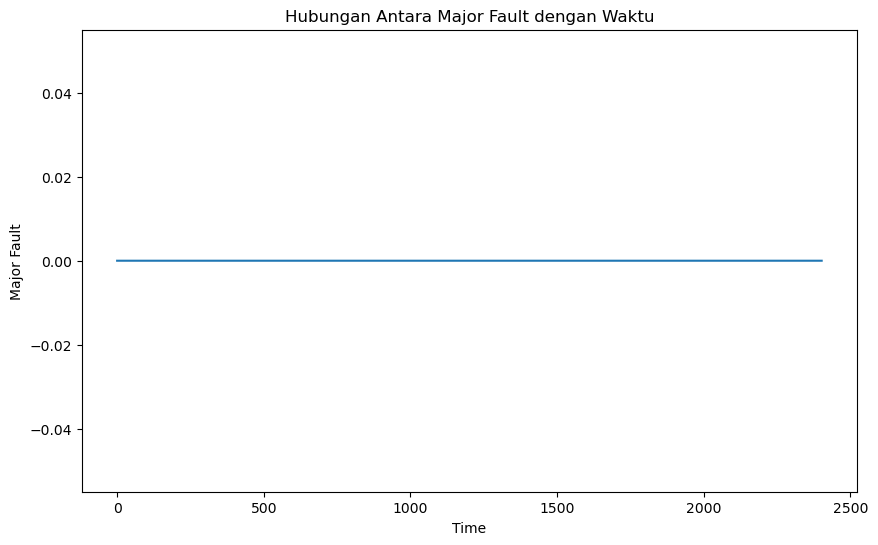

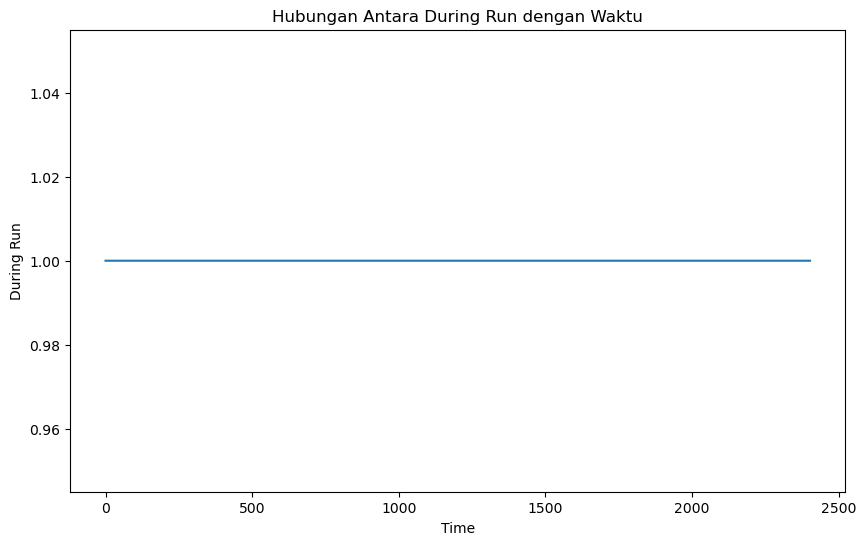

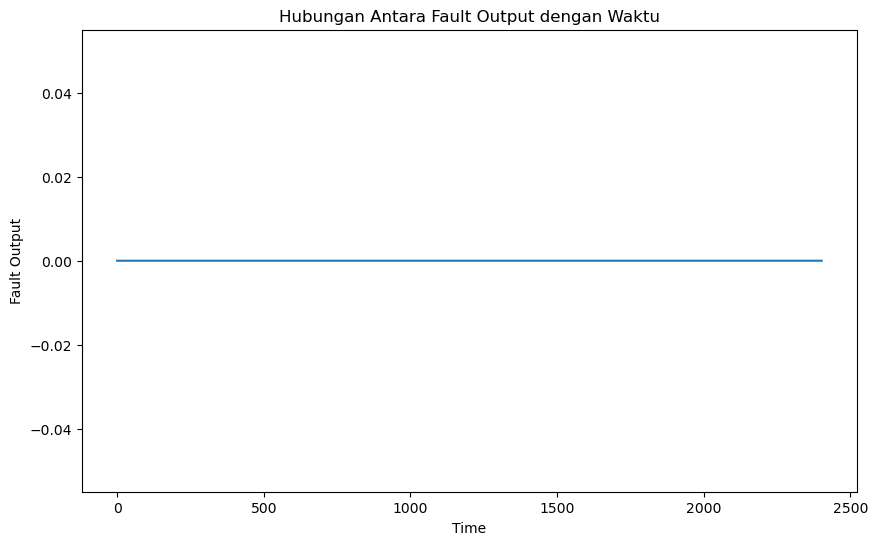

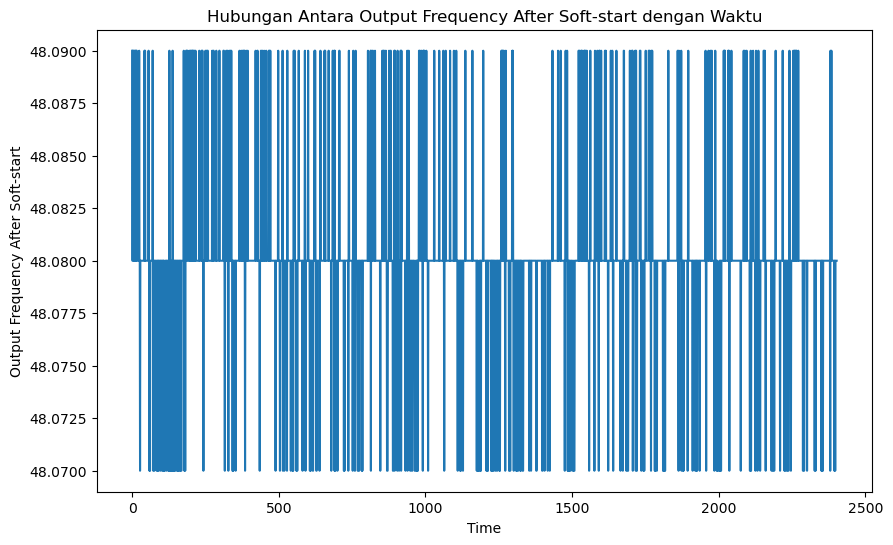

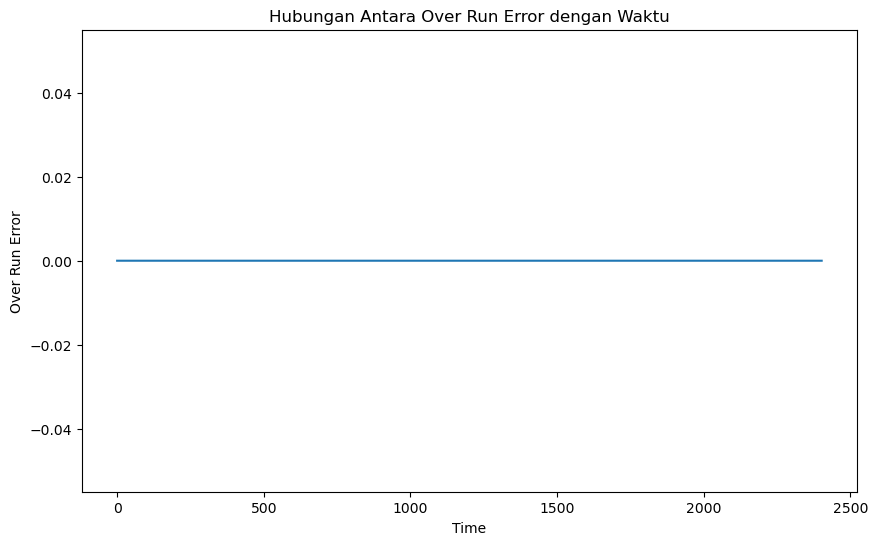

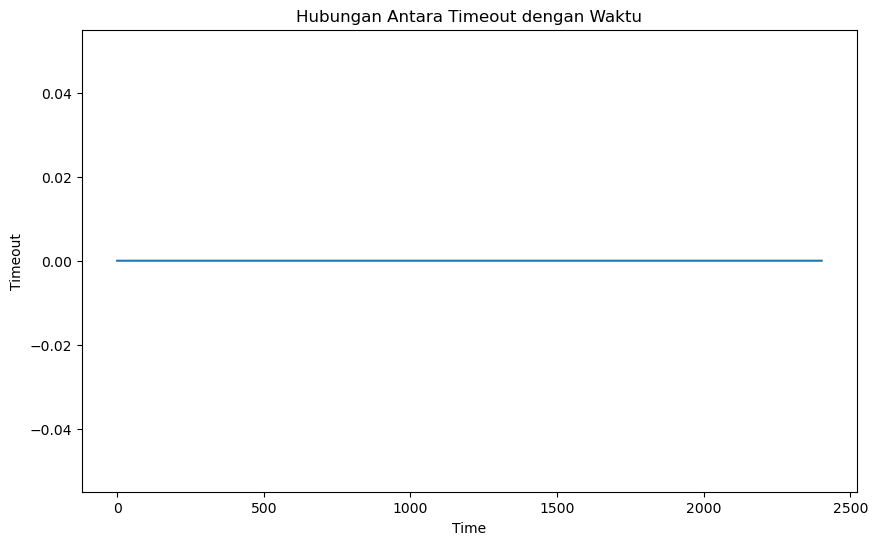

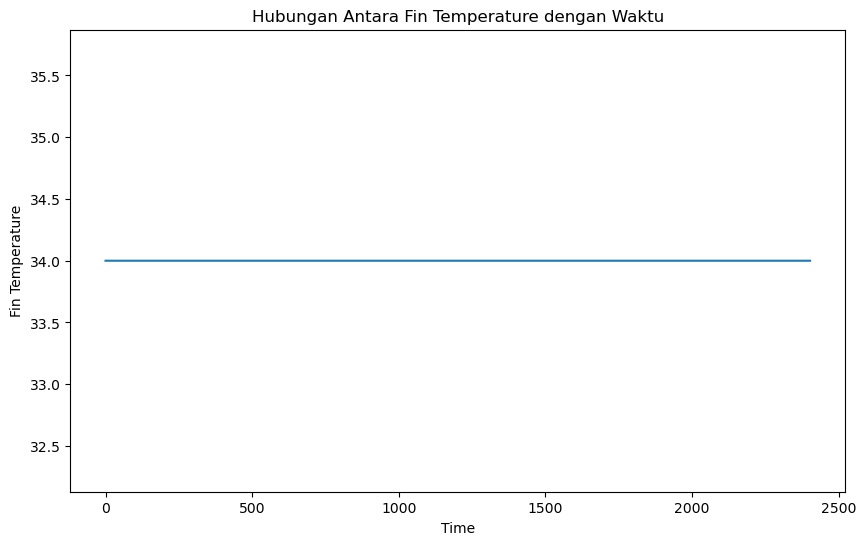

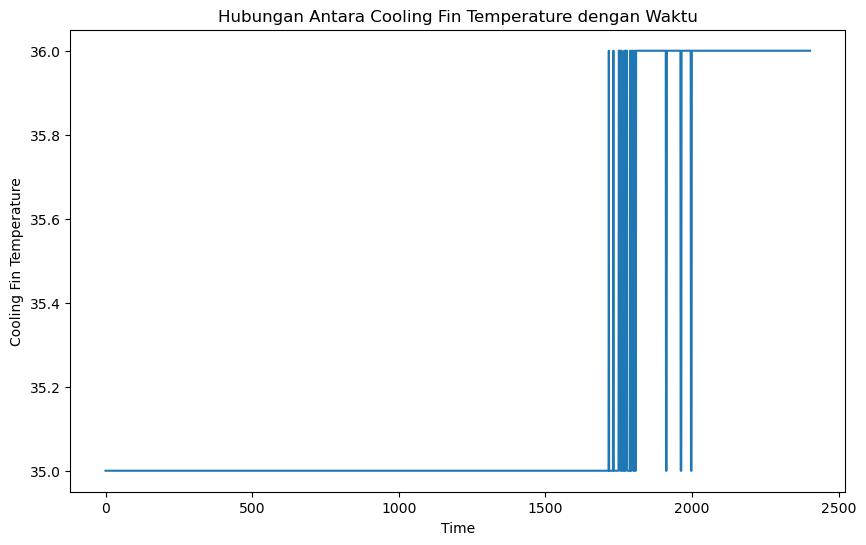

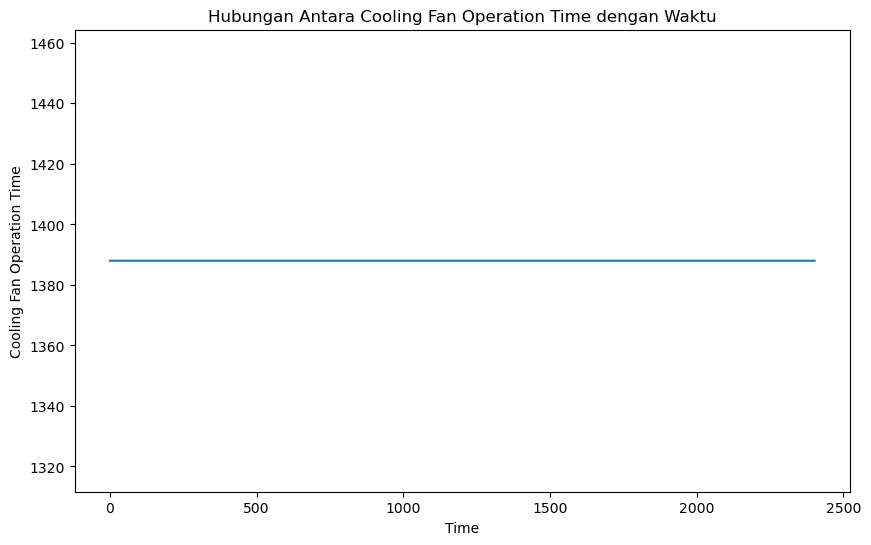

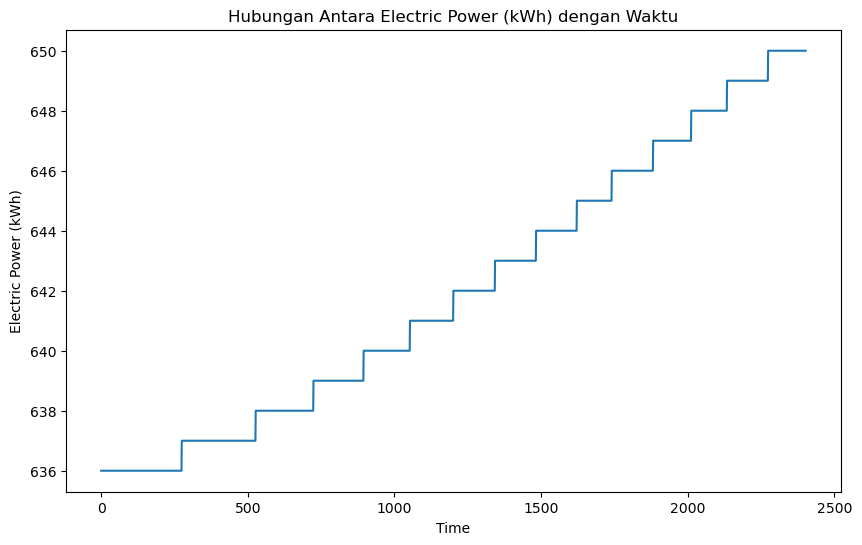

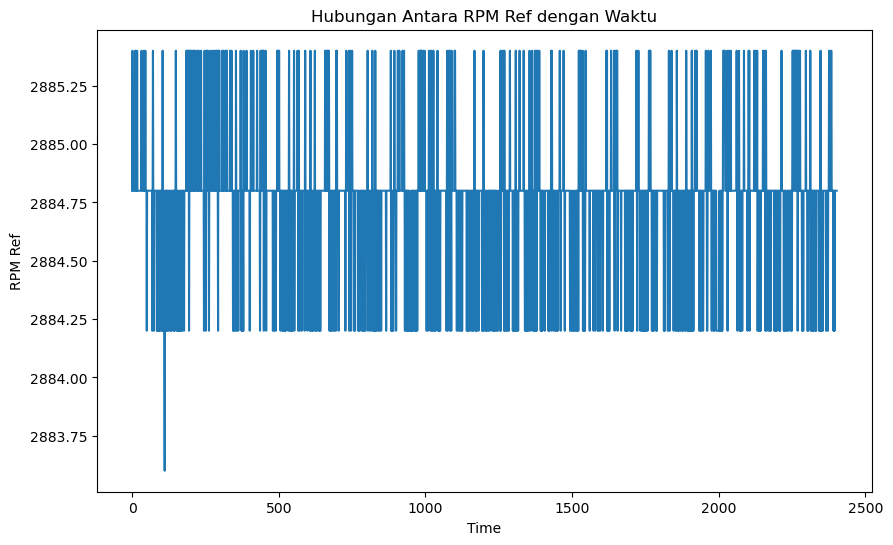

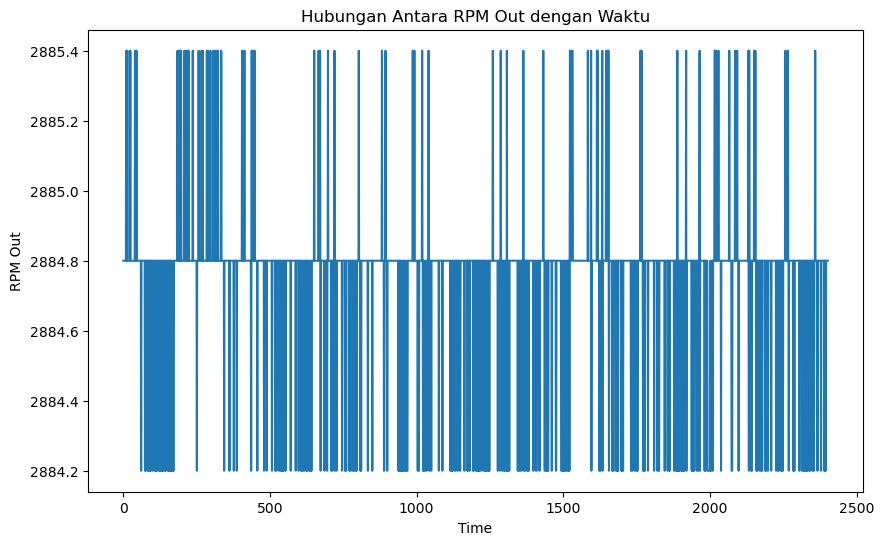

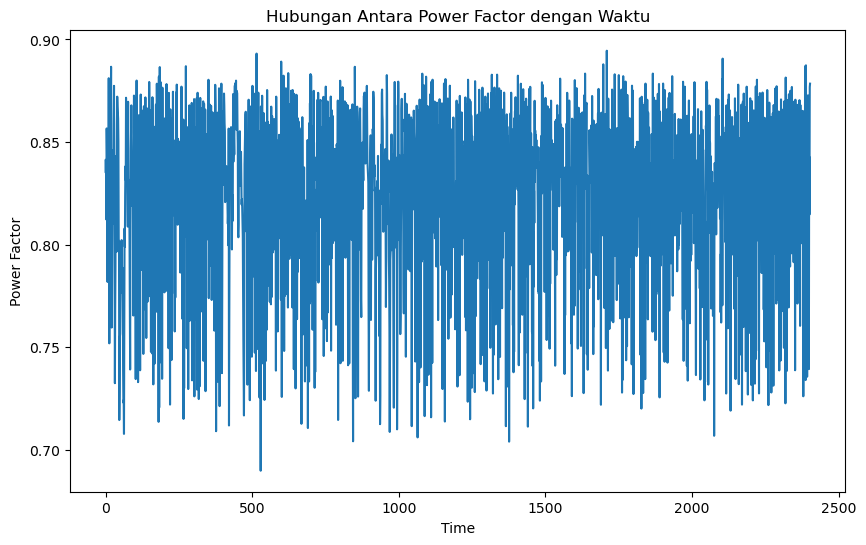

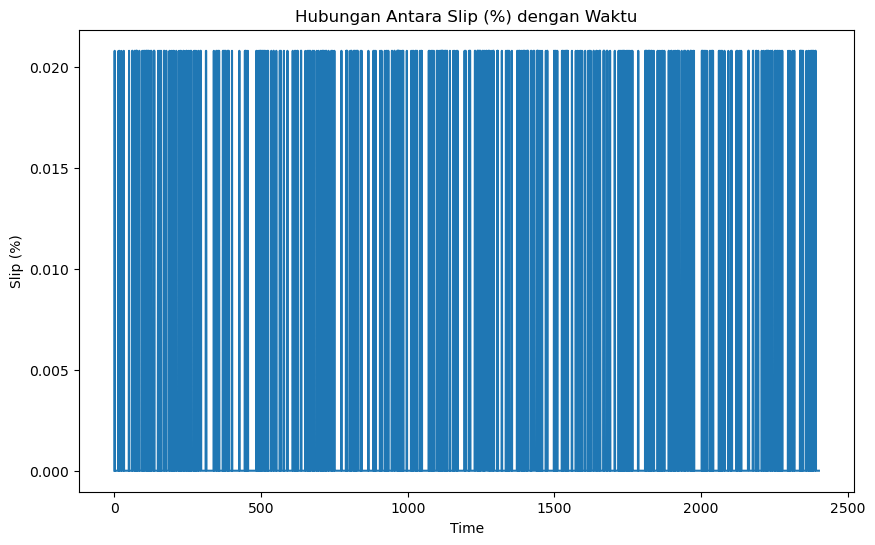

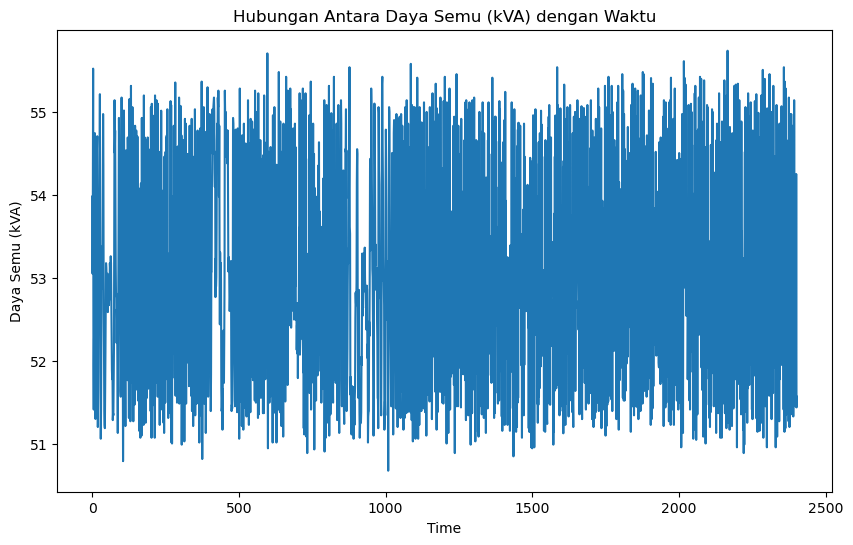

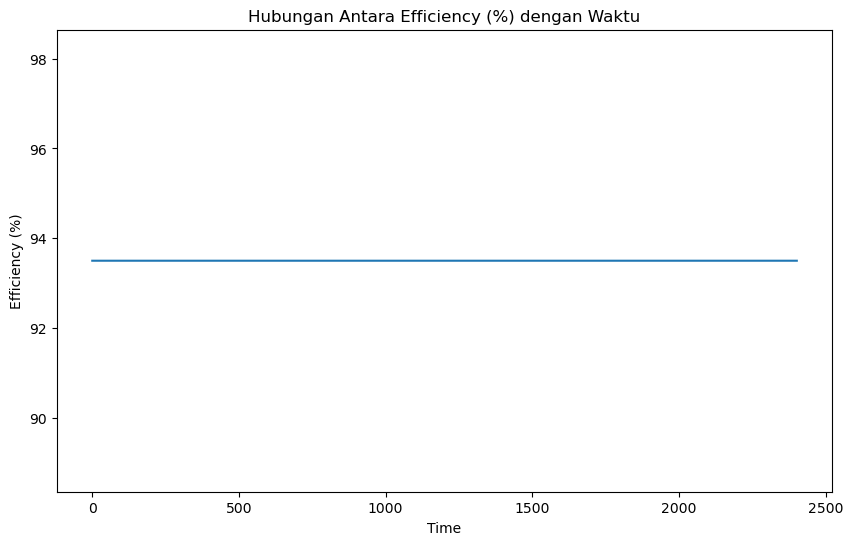

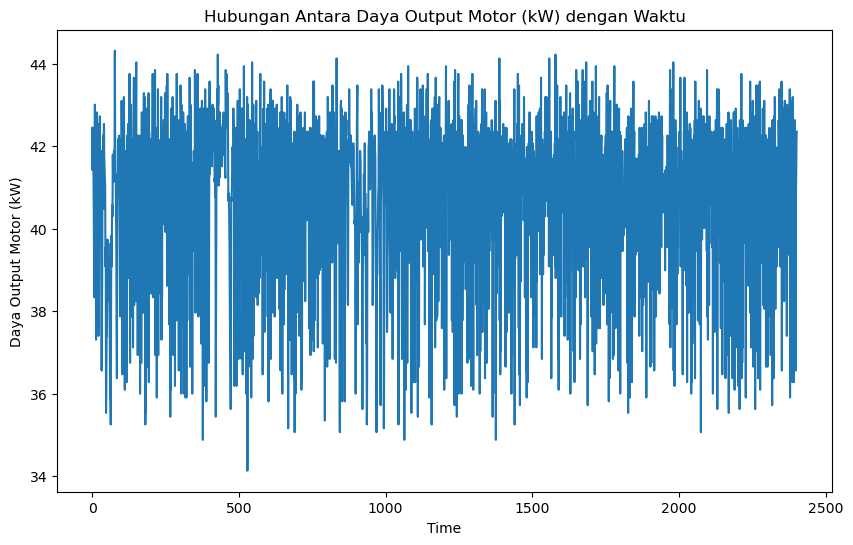

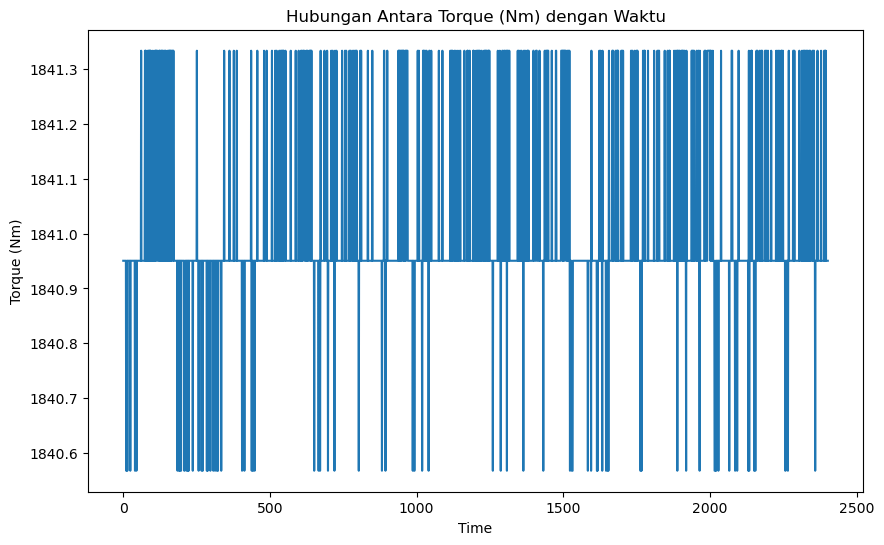

In [41]:
# Hubungan Antara Waktu dengan Variable Lain
for col in train.columns:
    if col != "Time":
        plt.figure(figsize=(10, 6))
        plt.plot(train.index, train[col], label=col)
        plt.xlabel("Time")
        plt.ylabel(col)
        plt.title(f"Hubungan Antara {col} dengan Waktu")
        plt.show()

Text(0.5, 1.0, 'Trend of Output Frequency, Current, and Power terhadap Waktu')

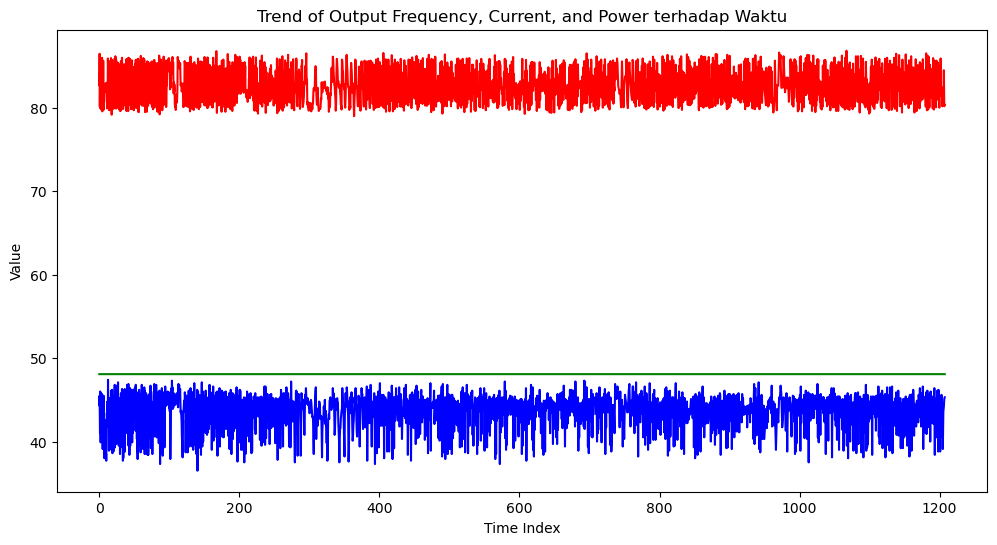

In [42]:
# Plot Output Frequency, Output Current, dan Output Power terhadap waktu
plt.figure(figsize=(12,6))
plt.plot(df['Time'], df['Output Frequency'], label='Output Frequency (Hz)', color='green')
plt.plot(df['Time'], df['Output Current'], label='Output Frequency (Hz)', color='red')
plt.plot(df['Time'], df['Output Power'], label='Output Frequency (Hz)', color='blue')

plt.xlabel('Time Index')
plt.ylabel('Value')
plt.title('Trend of Output Frequency, Current, and Power terhadap Waktu')

Dari grafik diatas, dapat dilihat bahwa trend frekuensi output, arus output, dan daya output menunjukkan bahwa:
1. Frekueni output yang cukup stabil di sekitar 48 Hz yang menunjukkan bahwa VFD dapat mempertahankan frekuensi ke motor dengan baik
2. Arus outpu mengalami fluktuasi yang mencerminkan adanya variasi pada load motor
3. Daya output juga mengalami fluktuasi karena adanya perubahan beban pada motor

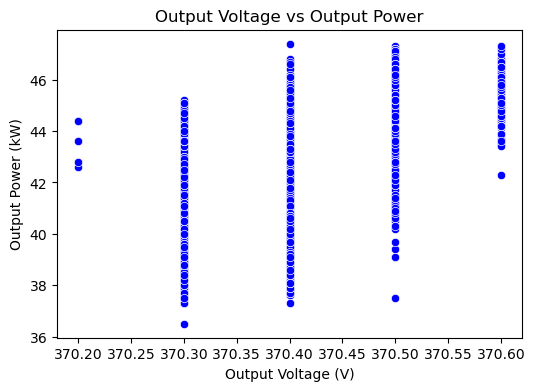

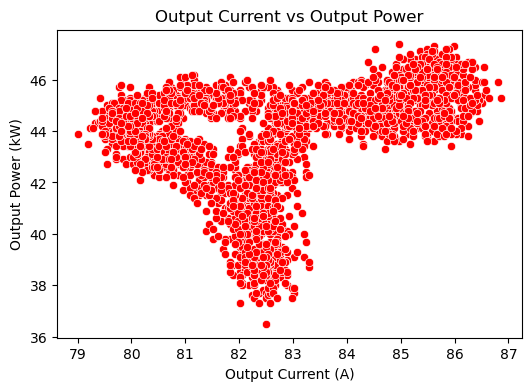

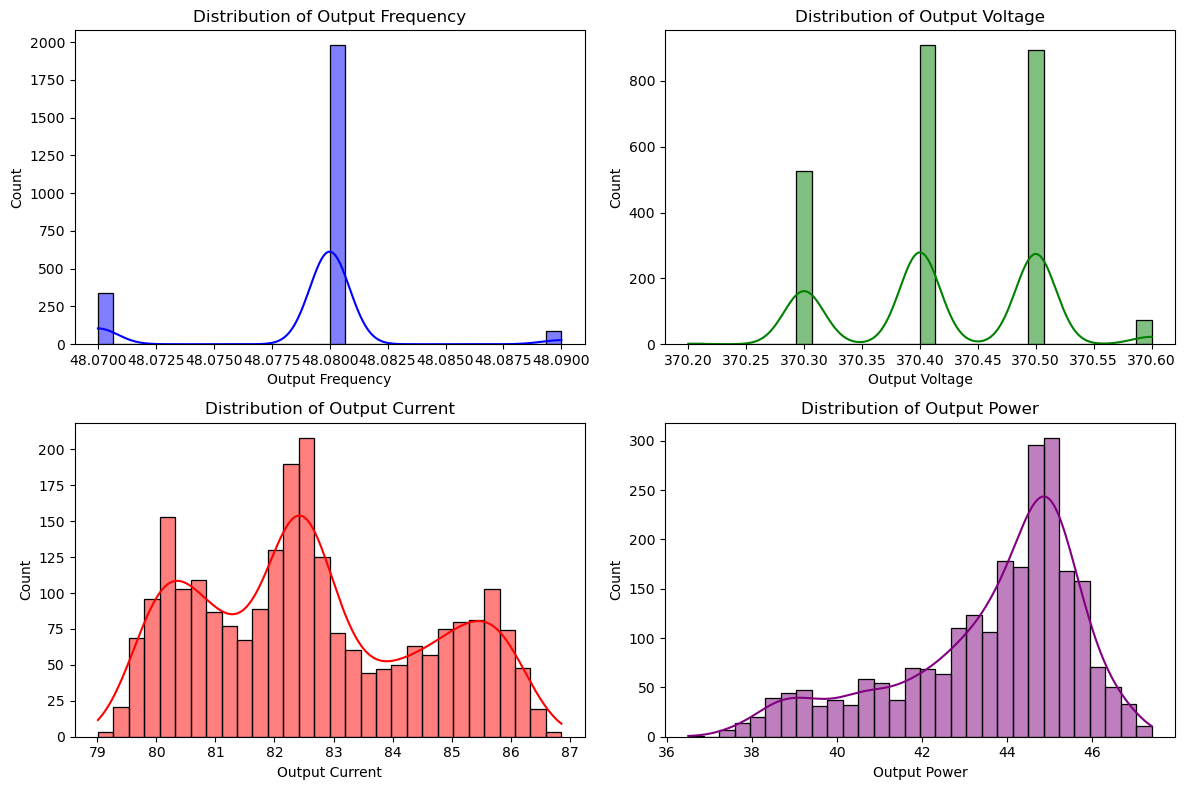

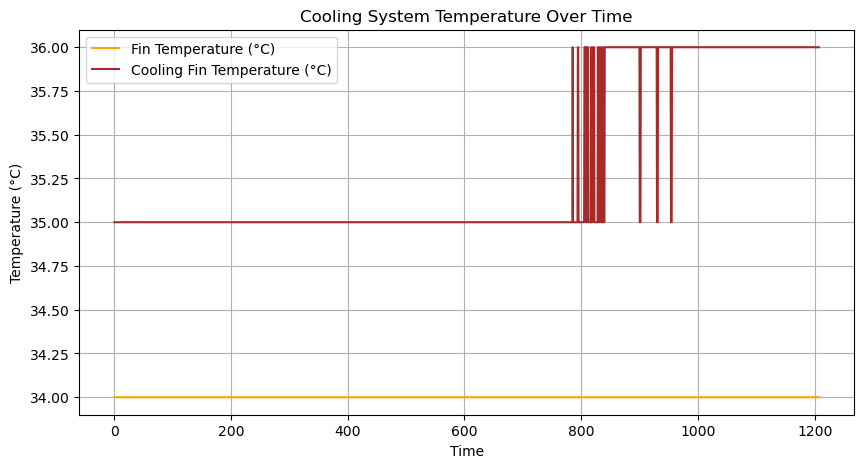

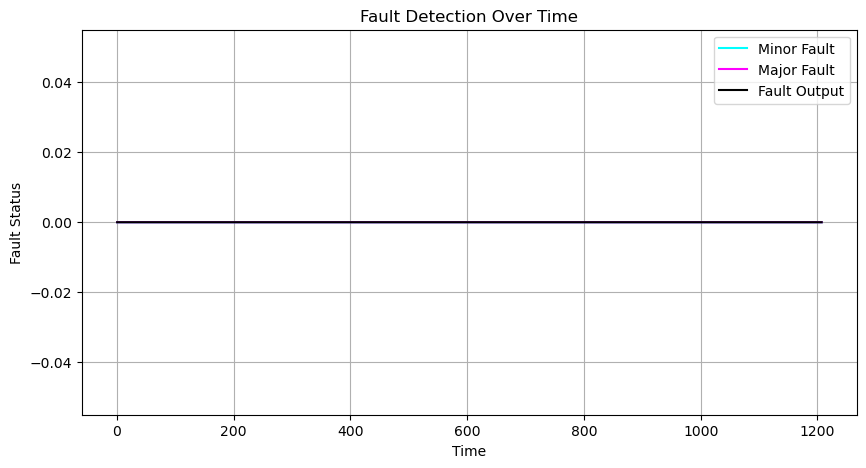

In [43]:
# 1. Scatter Plot: Output Voltage vs Output Power
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df["Output Voltage"], y=df["Output Power"], color="blue")
plt.xlabel("Output Voltage (V)")
plt.ylabel("Output Power (kW)")
plt.title("Output Voltage vs Output Power")
plt.show()

# 2. Scatter Plot: Output Current vs Output Power
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df["Output Current"], y=df["Output Power"], color="red")
plt.xlabel("Output Current (A)")
plt.ylabel("Output Power (kW)")
plt.title("Output Current vs Output Power")
plt.show()

# 3. Histogram Distribusi Data
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df["Output Frequency"], bins=30, kde=True, ax=axes[0, 0], color="blue")
axes[0, 0].set_title("Distribution of Output Frequency")

sns.histplot(df["Output Voltage"], bins=30, kde=True, ax=axes[0, 1], color="green")
axes[0, 1].set_title("Distribution of Output Voltage")

sns.histplot(df["Output Current"], bins=30, kde=True, ax=axes[1, 0], color="red")
axes[1, 0].set_title("Distribution of Output Current")

sns.histplot(df["Output Power"], bins=30, kde=True, ax=axes[1, 1], color="purple")
axes[1, 1].set_title("Distribution of Output Power")

plt.tight_layout()
plt.show()

# 4. Analisis Suhu Pendingin terhadap Waktu
plt.figure(figsize=(10, 5))
plt.plot(df["Time"], df["Fin Temperature"], label="Fin Temperature (°C)", color="orange")
plt.plot(df["Time"], df["Cooling Fin Temperature"], label="Cooling Fin Temperature (°C)", color="brown")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Cooling System Temperature Over Time")
plt.legend()
plt.grid()
plt.show()

# 5. Analisis Fault (Kesalahan) terhadap Waktu
plt.figure(figsize=(10, 5))
plt.plot(df["Time"], df["Minor Fault"], label="Minor Fault", color="cyan")
plt.plot(df["Time"], df["Major Fault"], label="Major Fault", color="magenta")
plt.plot(df["Time"], df["Fault Output"], label="Fault Output", color="black")

plt.xlabel("Time")
plt.ylabel("Fault Status")
plt.title("Fault Detection Over Time")
plt.legend()
plt.grid()
plt.show()


Output Voltage vs Output Power 
1. Dari grafik scatter plot tersebut dapat dilihat bahwa tegangan output berkorelasi dengan daya output. 
2. Pola tersebut menunjukkan hubungan linear yang normal karena daya listrik bergantung pada tegangan dan arus

Output Current vs Output Voltage
1. Arus output juga memiliki hubungan linear dengan output power
2. Jika terdapaat deviasi yang signifikan pada pola grafik, bisa jadi terdapat masalah pada load motor atau vfd

Histogram Distribusi Data


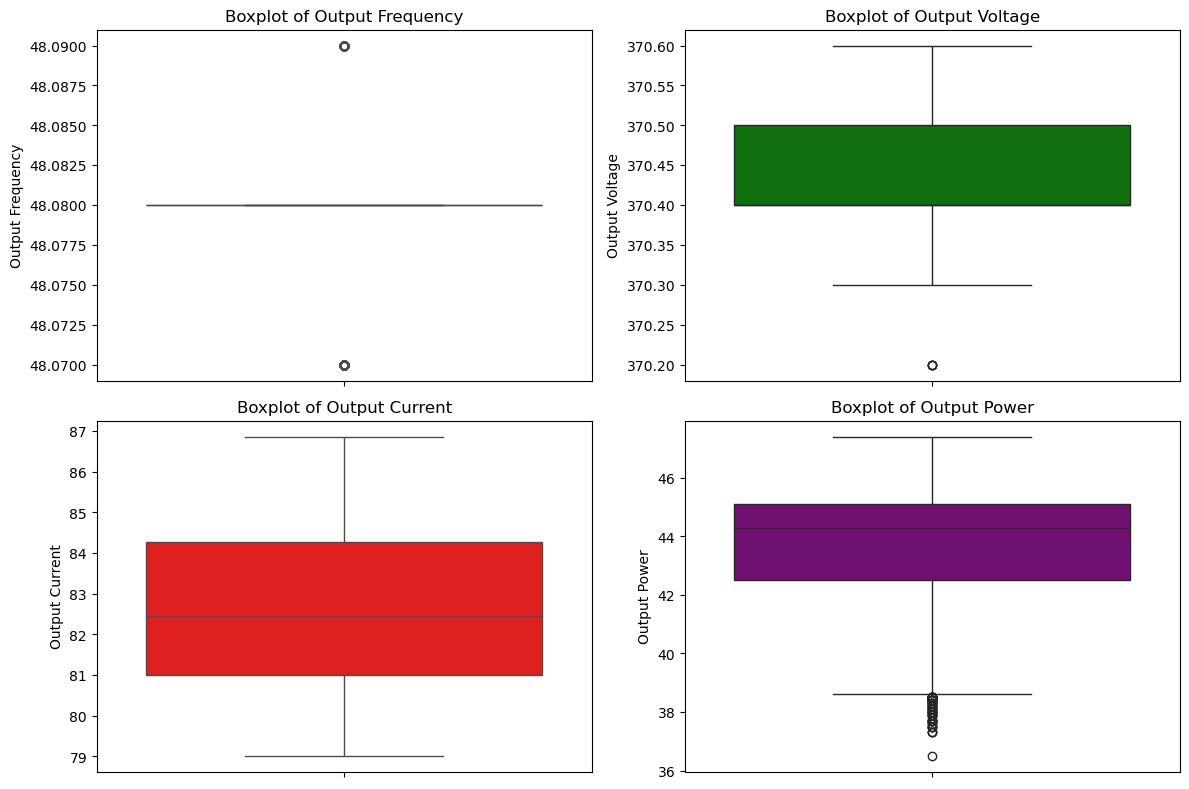

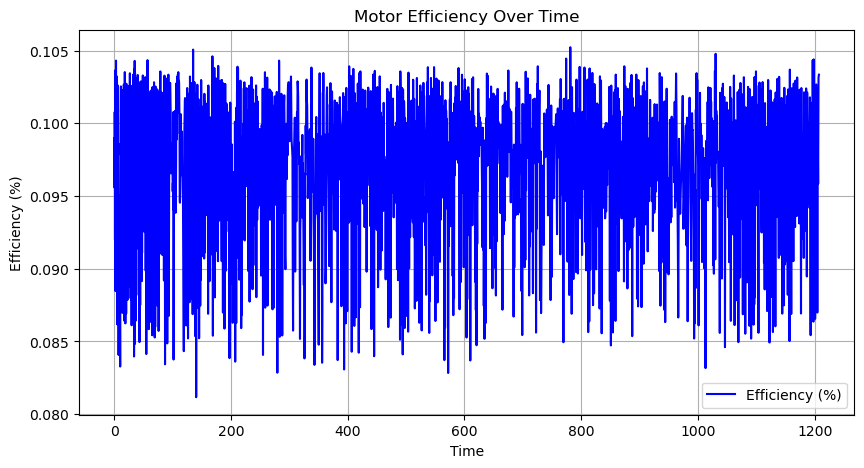

(0, 1)

In [44]:
# 1. Boxplot untuk melihat anomali dalam distribusi data utama
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.boxplot(y=df["Output Frequency"], ax=axes[0, 0], color="blue")
axes[0, 0].set_title("Boxplot of Output Frequency")

sns.boxplot(y=df["Output Voltage"], ax=axes[0, 1], color="green")
axes[0, 1].set_title("Boxplot of Output Voltage")

sns.boxplot(y=df["Output Current"], ax=axes[1, 0], color="red")
axes[1, 0].set_title("Boxplot of Output Current")

sns.boxplot(y=df["Output Power"], ax=axes[1, 1], color="purple")
axes[1, 1].set_title("Boxplot of Output Power")

plt.tight_layout()
plt.show()

# 2. Deteksi Outlier menggunakan Z-score (mengambil threshold |Z| > 3)
def detect_outliers_zscore(data, column):
    mean = np.mean(data[column])
    std = np.std(data[column])
    z_scores = (data[column] - mean) / std
    outliers = data[np.abs(z_scores) > 3]
    return outliers

outliers_current = detect_outliers_zscore(df, "Output Current")
outliers_power = detect_outliers_zscore(df, "Output Power")

# 3. Perhitungan Efisiensi Motor
cos_phi = 0.85
df["Input Power"] = np.sqrt(3) * df["Output Voltage"] * df["Output Current"] * cos_phi  # P_in
df["Efficiency (%)"] = (df["Output Power"] / df["Input Power"]) * 100

# 4. Plot Efisiensi Motor terhadap Waktu
plt.figure(figsize=(10, 5))
plt.plot(df["Time"], df["Efficiency (%)"], label="Efficiency (%)", color="blue")
plt.xlabel("Time")
plt.ylabel("Efficiency (%)")
plt.title("Motor Efficiency Over Time")
plt.legend()
plt.grid()
plt.show()

# Menampilkan jumlah outlier yang ditemukan
len(outliers_current), len(outliers_power)


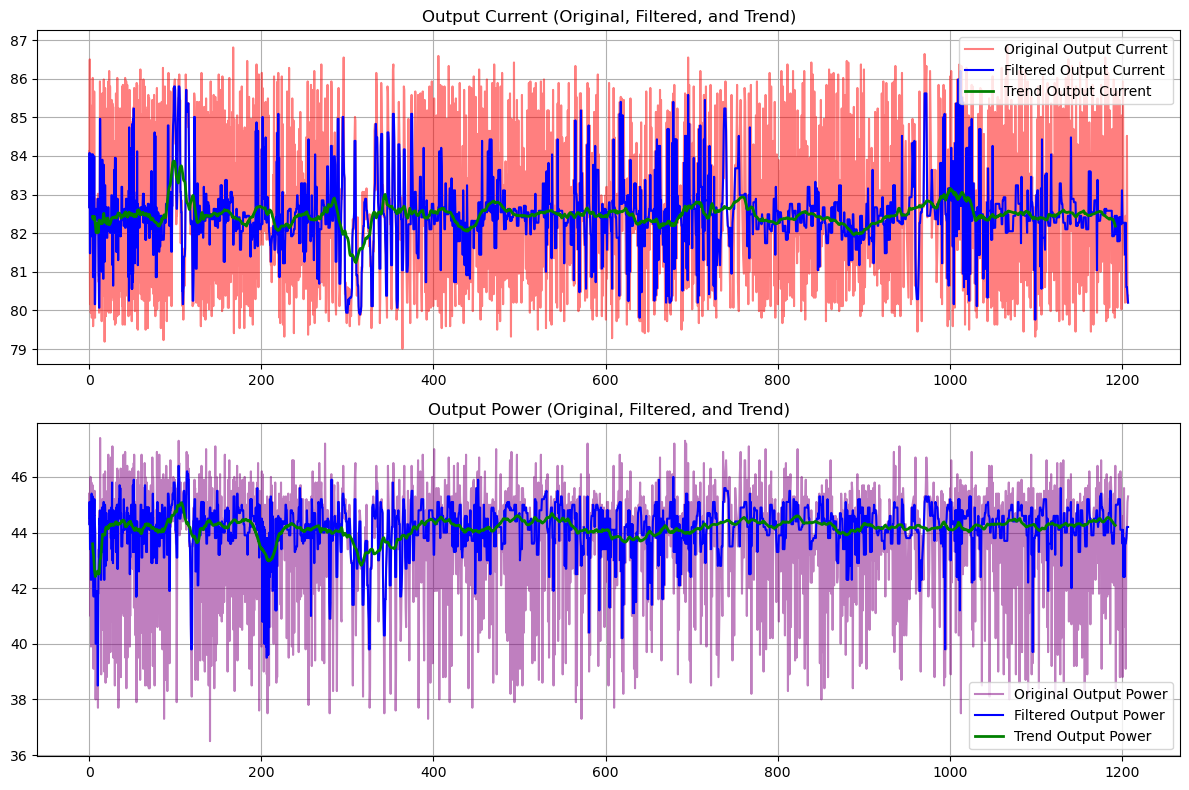

In [45]:
# Analisis Trend Jangka Panjang
from scipy.signal import medfilt

# 1. Filter Outlier dengan Median Filter
df["Filtered Output Current"] = medfilt(df["Output Current"], kernel_size=5)
df["Filtered Output Power"] = medfilt(df["Output Power"], kernel_size=5)

# 2. Deteksi Tren Jangka Panjang dengan Moving Average (Window 50)
df["Trend Output Current"] = df["Filtered Output Current"].rolling(window=50, center=True).mean()
df["Trend Output Power"] = df["Filtered Output Power"].rolling(window=50, center=True).mean()

# 3. Plot Data Sebelum dan Sesudah Filtering untuk Perbandingan
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(df["Time"], df["Output Current"], label="Original Output Current", alpha=0.5, color="red")
axes[0].plot(df["Time"], df["Filtered Output Current"], label="Filtered Output Current", color="blue")
axes[0].plot(df["Time"], df["Trend Output Current"], label="Trend Output Current", color="green", linewidth=2)
axes[0].set_title("Output Current (Original, Filtered, and Trend)")
axes[0].legend()
axes[0].grid()

axes[1].plot(df["Time"], df["Output Power"], label="Original Output Power", alpha=0.5, color="purple")
axes[1].plot(df["Time"], df["Filtered Output Power"], label="Filtered Output Power", color="blue")
axes[1].plot(df["Time"], df["Trend Output Power"], label="Trend Output Power", color="green", linewidth=2)
axes[1].set_title("Output Power (Original, Filtered, and Trend)")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


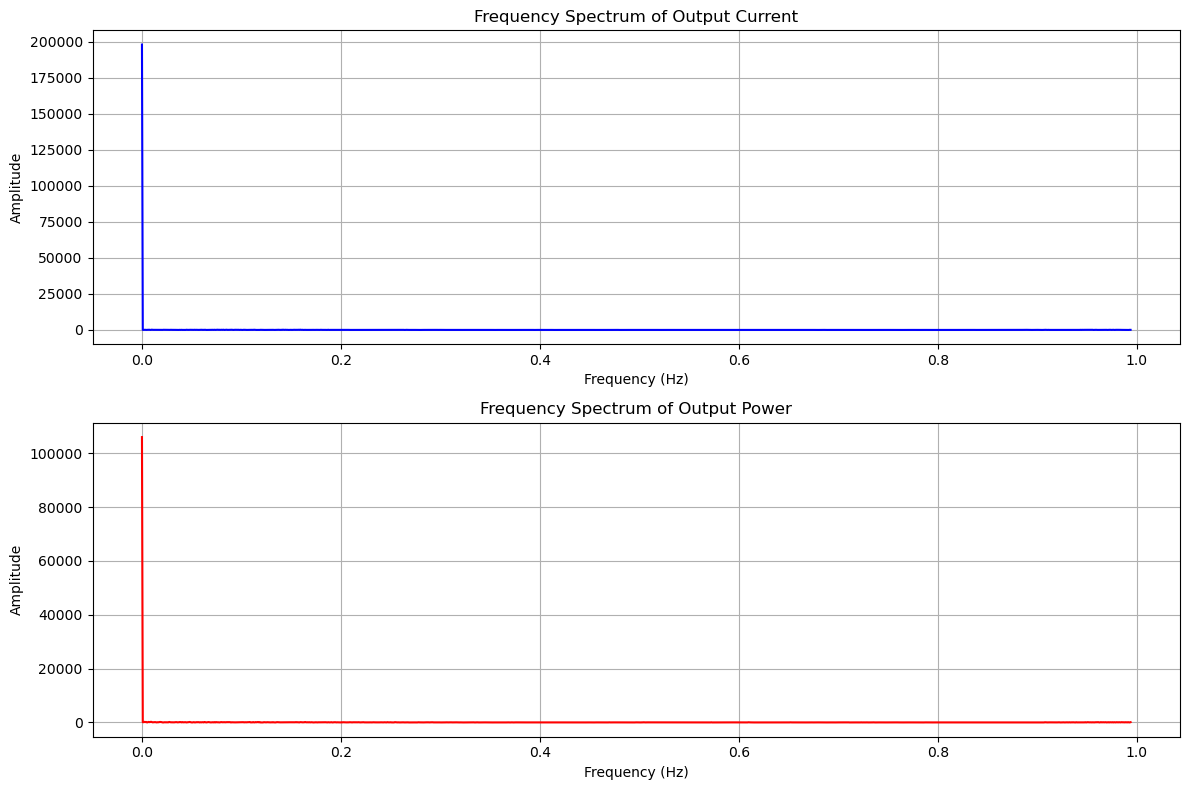

In [46]:
# 1. Analisis Pola Siklus dengan FFT (Fast Fourier Transform)
from scipy.fftpack import fft, fftfreq

# Menghilangkan NaN dari data yang telah difilter
filtered_current = df["Filtered Output Current"].dropna().values
filtered_power = df["Filtered Output Power"].dropna().values

# Sampling rate berdasarkan selisih waktu rata-rata antar data
time_intervals = np.diff(df["Time"].dropna())
sampling_rate = 1 / np.mean(time_intervals)  # Hz

# FFT untuk Output Current
N = len(filtered_current)
freqs_current = fftfreq(N, d=1/sampling_rate)
fft_current = np.abs(fft(filtered_current))

# FFT untuk Output Power
N = len(filtered_power)
freqs_power = fftfreq(N, d=1/sampling_rate)
fft_power = np.abs(fft(filtered_power))

# 2. Visualisasi Spektrum Frekuensi
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(freqs_current[:N // 2], fft_current[:N // 2], color="blue")
axes[0].set_title("Frequency Spectrum of Output Current")
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("Amplitude")
axes[0].grid()

axes[1].plot(freqs_power[:N // 2], fft_power[:N // 2], color="red")
axes[1].set_title("Frequency Spectrum of Output Power")
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Amplitude")
axes[1].grid()

plt.tight_layout()
plt.show()


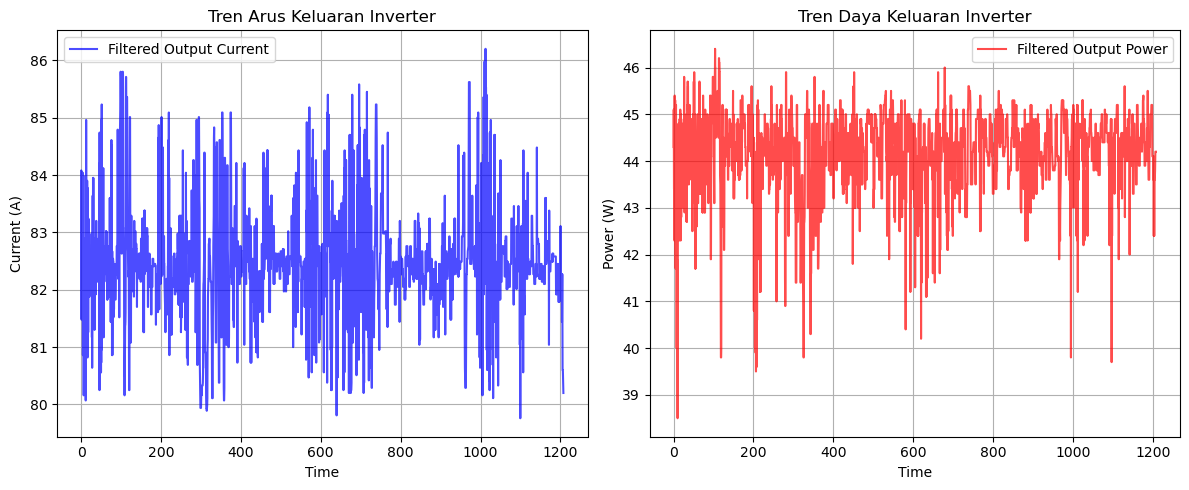

In [47]:
# Plot hubungan antara arus dan daya keluaran inverter dalam jangka waktu tertentu

plt.figure(figsize=(12, 5))

# Plot tren Output Current
plt.subplot(1, 2, 1)
plt.plot(df["Time"], df["Filtered Output Current"], label="Filtered Output Current", color="blue", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Current (A)")
plt.title("Tren Arus Keluaran Inverter")
plt.legend()
plt.grid()

# Plot tren Output Power
plt.subplot(1, 2, 2)
plt.plot(df["Time"], df["Filtered Output Power"], label="Filtered Output Power", color="red", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Power (W)")
plt.title("Tren Daya Keluaran Inverter")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [48]:
# 1. Menghitung THD (Total Harmonic Distortion) untuk Output Current dan Output Power
def calculate_thd(signal_fft, fundamental_freq, freqs):
    """Menghitung Total Harmonic Distortion (THD) berdasarkan FFT"""
    fundamental_index = np.argmin(np.abs(freqs - fundamental_freq))
    fundamental_amplitude = signal_fft[fundamental_index]
    
    if fundamental_amplitude == 0:
        return np.nan  # Hindari pembagian nol
    
    harmonic_power = np.sum(signal_fft[fundamental_index+1:] ** 2)  # Jumlah daya harmonik di atas fundamental
    thd = np.sqrt(harmonic_power) / fundamental_amplitude
    return thd * 100  # Dalam persen

# Asumsi fundamental frequency dari suplai (50 Hz)
fundamental_freq = 50  

# Menghitung THD untuk Output Current dan Output Power
thd_current = calculate_thd(fft_current, fundamental_freq, freqs_current)
thd_power = calculate_thd(fft_power, fundamental_freq, freqs_power)

thd_current, thd_power


(3284.4142173698983, 3195.6135893376127)

### 3. Model Selection

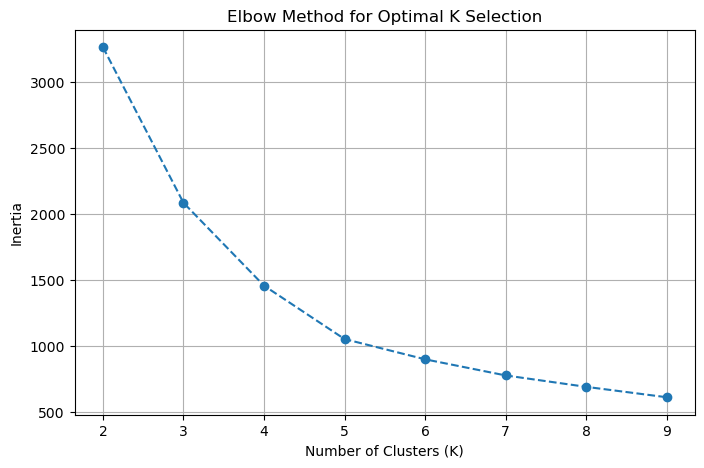

In [49]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Menggunakan arus dan daya yang telah difilter untuk clustering
current_data = df["Filtered Output Current"].values
power_data = df["Filtered Output Power"].values

# Menyiapkan fitur untuk clustering
features = np.column_stack((current_data, power_data))

# Normalisasi data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Menentukan jumlah cluster optimal dengan Metode Elbow
inertia = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot Metode Elbow untuk menentukan jumlah cluster optimal
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K Selection")
plt.grid()
plt.show()


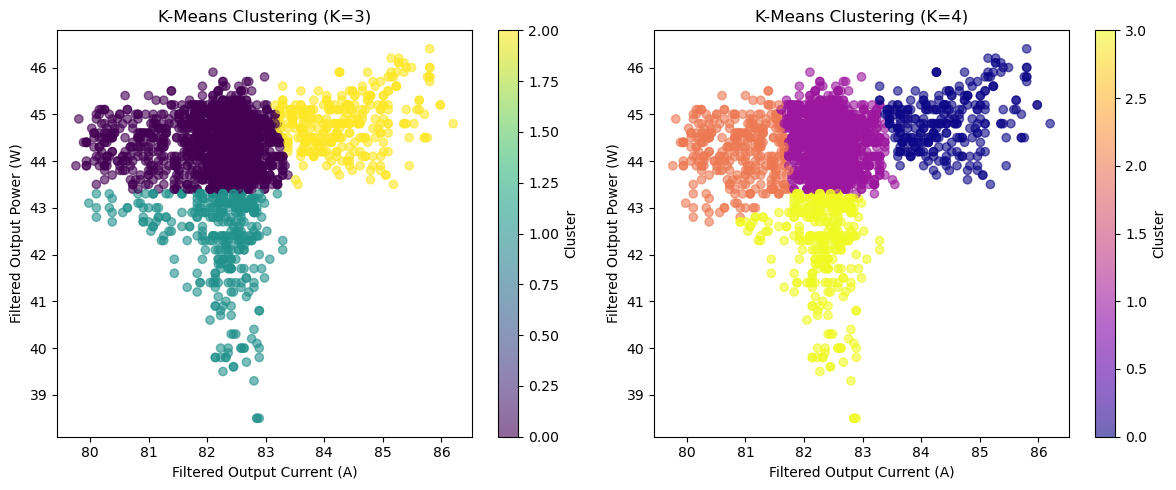

In [50]:
# Menerapkan K-Means Clustering dengan K=3 dan K=4
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10).fit(features_scaled)
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10).fit(features_scaled)

# Menambahkan hasil clustering ke dalam DataFrame
df["Cluster_3"] = kmeans_3.labels_
df["Cluster_4"] = kmeans_4.labels_

# Visualisasi clustering untuk K=3
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(df["Filtered Output Current"], df["Filtered Output Power"], c=df["Cluster_3"], cmap="viridis", alpha=0.6)
plt.xlabel("Filtered Output Current (A)")
plt.ylabel("Filtered Output Power (W)")
plt.title("K-Means Clustering (K=3)")
plt.colorbar(label="Cluster")

# Visualisasi clustering untuk K=4
plt.subplot(1, 2, 2)
plt.scatter(df["Filtered Output Current"], df["Filtered Output Power"], c=df["Cluster_4"], cmap="plasma", alpha=0.6)
plt.xlabel("Filtered Output Current (A)")
plt.ylabel("Filtered Output Power (W)")
plt.title("K-Means Clustering (K=4)")
plt.colorbar(label="Cluster")

plt.tight_layout()
plt.show()


In [51]:
# Menyiapkan data untuk Autoencoder (menggunakan fitur yang sudah distandarisasi)
X_train = features_scaled

# Membangun model Autoencoder
input_dim = X_train.shape[1]

autoencoder = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(8, activation="relu"),  # Layer encoding (dimensi lebih kecil)
    layers.Dense(4, activation="relu"),  # Layer encoding lebih dalam
    layers.Dense(8, activation="relu"),  # Layer decoding
    layers.Dense(input_dim, activation="linear")  # Output harus sama dengan input
])

# Kompilasi model
autoencoder.compile(optimizer="adam", loss="mse")

# Melatih Autoencoder
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3138 - val_loss: 0.5793
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8603 - val_loss: 0.3959
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6445 - val_loss: 0.2815
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4927 - val_loss: 0.2265
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4361 - val_loss: 0.1687
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2740 - val_loss: 0.1039
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1759 - val_loss: 0.0534
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0873 - val_loss: 0.0341
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0561 - val_loss: 0.0252
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0366 - val_loss: 0.0203
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0339 - val_loss: 0.0151
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0261 - val_lo

In [52]:
# Ambil variable
x = train[['Frequency Reference', 'Output Current', 'Output Power', 'Output Voltage', 'Fin Temperature', 'Cooling Fin Temperature']].values
y = train[['Output Frequency']].values

# Normalisasi data
scaler = StandardScaler()
x = scaler.fit_transform(x)

# Split train-test (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [53]:
# Model ANN dengan 3 hidden layer
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Output 1 nilai (Frekuensi Output)
])

# Compile Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Tampilkan Arsitektur Model
model.summary()


c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2190.6931 - mae: 46.7750 - val_loss: 1390.4547 - val_mae: 37.1643
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 865.7880 - mae: 27.4360 - val_loss: 81.3005 - val_mae: 7.1065
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 98.0248 - mae: 7.9604 - val_loss: 48.1532 - val_mae: 5.4269
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 71.8045 - mae: 6.8313 - val_loss: 34.1845 - val_mae: 4.6102
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53.1063 - mae: 5.8908 - val_loss: 25.2932 - val_mae: 4.0023
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45.3264 - mae: 5.2837 - val_loss: 19.0604 - val_mae: 3.4608
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.8893 - mae: 4.7548 - val_loss: 14.1247 - val_mae: 2.9627
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.5911 - mae: 4.4736 - val_loss: 12.1332 - val_mae: 2.8383
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0

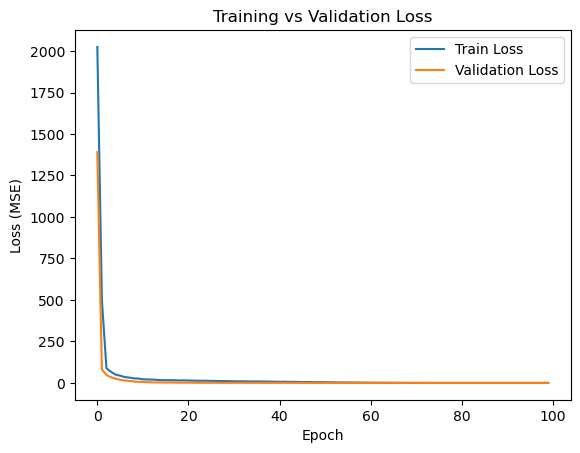

In [55]:
# Plot loss function
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


### 4. Evaluation and Testing

In [56]:
x_current = pd.read_csv('yaskawa3_test.csv')
x_current['Time'] = pd.to_timedelta(x_current['Time']).dt.total_seconds()

x_current.head(15)


,Time,Frequency Reference,Output Frequency,Output Current,Output Power,Output Voltage,Minor Fault,Major Fault,During Run,Fault Output,Output Frequency After Soft-start,Over Run Error,Timeout,Fin Temperature,Cooling Fin Temperature,Cooling Fan Operation Time,Electric Power (kWh)
0,0.188,48.08,48.08,82.54,42.4,370.4,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,35.0,1388.0,627.0
1,0.336,48.08,48.08,82.71,38.1,370.3,0.0,0.0,1.0,0.0,48.07,0.0,0.0,34.0,35.0,1388.0,627.0
2,0.487,48.09,48.08,83.20,42.5,370.5,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,35.0,1388.0,627.0
3,0.632,48.08,48.08,83.33,44.4,370.5,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,35.0,1388.0,627.0
4,0.775,48.07,48.08,85.93,47.5,370.4,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,35.0,1388.0,627.0
5,0.918,48.09,48.08,84.43,45.5,370.5,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,35.0,1388.0,627.0
6,1.058,48.08,48.08,80.03,44.8,370.4,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,35.0,1388.0,627.0
7,1.183,48.09,48.09,81.61,42.9,370.4,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,35.0,1388.0,627.0
8,1.333,48.09,48.08,82.05,38.6,370.4,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,35.0,1388.0,627.0
9,1.474,48.07,48.07,82.32,44.1,370.4,0.0,0.0,1.0,0.0,48.08,0.0,0.0,34.0,35.0,1388.0,627.0


In [57]:
# Test 10 data
features = ['Frequency Reference', 'Output Current', 'Output Power', 'Output Voltage', 'Fin Temperature', 'Cooling Fin Temperature']
x_current[features] = scaler.transform(x_current[features])

x_current['Predicted Frequency'] = np.nan
x_current.loc[:100, 'Predicted Frequency'] = x_current.head(100).apply(
    lambda row: model.predict(np.array([row[features]]))[0][0], axis=1
)

x_current['error (%)'] = abs(x_current['Output Frequency'] - x_current['Predicted Frequency'])*100/x_current['Output Frequency']
x_current.head(15)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

,Time,Frequency Reference,Output Frequency,Output Current,Output Power,Output Voltage,Minor Fault,Major Fault,During Run,Fault Output,Output Frequency After Soft-start,Over Run Error,Timeout,Fin Temperature,Cooling Fin Temperature,Cooling Fan Operation Time,Electric Power (kWh),Predicted Frequency,error (%)
0,0.188,0.195298,48.08,-0.045256,-0.567329,-0.256501,0.0,0.0,1.0,0.0,48.08,0.0,0.0,0.0,-0.583277,1388.0,627.0,47.977501,0.213184
1,0.336,0.195298,48.08,0.042982,-2.584864,-1.474629,0.0,0.0,1.0,0.0,48.07,0.0,0.0,0.0,-0.583277,1388.0,627.0,47.929024,0.314011
2,0.487,2.158897,48.08,0.297314,-0.520409,0.961627,0.0,0.0,1.0,0.0,48.08,0.0,0.0,0.0,-0.583277,1388.0,627.0,47.892506,0.389963
3,0.632,0.195298,48.08,0.364790,0.371060,0.961627,0.0,0.0,1.0,0.0,48.08,0.0,0.0,0.0,-0.583277,1388.0,627.0,47.924355,0.323722
4,0.775,-1.768302,48.08,1.714309,1.825562,-0.256501,0.0,0.0,1.0,0.0,48.08,0.0,0.0,0.0,-0.583277,1388.0,627.0,47.988041,0.191263
5,0.918,2.158897,48.08,0.935741,0.887174,0.961627,0.0,0.0,1.0,0.0,48.08,0.0,0.0,0.0,-0.583277,1388.0,627.0,47.894657,0.385488
6,1.058,0.195298,48.08,-1.348061,0.558738,-0.256501,0.0,0.0,1.0,0.0,48.08,0.0,0.0,0.0,-0.583277,1388.0,627.0,47.917980,0.336980
7,1.183,2.158897,48.09,-0.527969,-0.332732,-0.256501,0.0,0.0,1.0,0.0,48.08,0.0,0.0,0.0,-0.583277,1388.0,627.0,47.948364,0.294522
8,1.333,2.158897,48.08,-0.299589,-2.350267,-0.256501,0.0,0.0,1.0,0.0,48.08,0.0,0.0,0.0,-0.583277,1388.0,627.0,47.820068,0.540623
9,1.474,-1.768302,48.07,-0.159446,0.230302,-0.256501,0.0,0.0,1.0,0.0,48.08,0.0,0.0,0.0,-0.583277,1388.0,627.0,48.009480,0.125901


In [58]:
x_current.tail(15)

,Time,Frequency Reference,Output Frequency,Output Current,Output Power,Output Voltage,Minor Fault,Major Fault,During Run,Fault Output,Output Frequency After Soft-start,Over Run Error,Timeout,Fin Temperature,Cooling Fin Temperature,Cooling Fan Operation Time,Electric Power (kWh),Predicted Frequency,error (%)
1244,634.742,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN
1245,634.927,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN
1246,635.115,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN
1247,635.319,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN
1248,635.508,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN
1249,635.711,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN
1250,636.069,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN
1251,636.414,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN
1252,636.774,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN
1253,637.132,-9440.792019,0.0,-42.8873,-20.461166,-4512.202445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-34.0,-81.003774,0.0,0.0,NaN,NaN


Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.6873 - val_loss: 0.6192
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6003 - val_loss: 0.6020
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5900 - val_loss: 0.5954
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5772 - val_loss: 0.5842
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5750 - val_loss: 0.5772
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5694 - val_loss: 0.5772
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5641 - val_loss: 0.5715
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5662 - val_loss: 0.5727
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5589 - val_loss: 0.5684
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5602 - val_loss: 0.5648
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5571 - val_loss: 0.5646
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

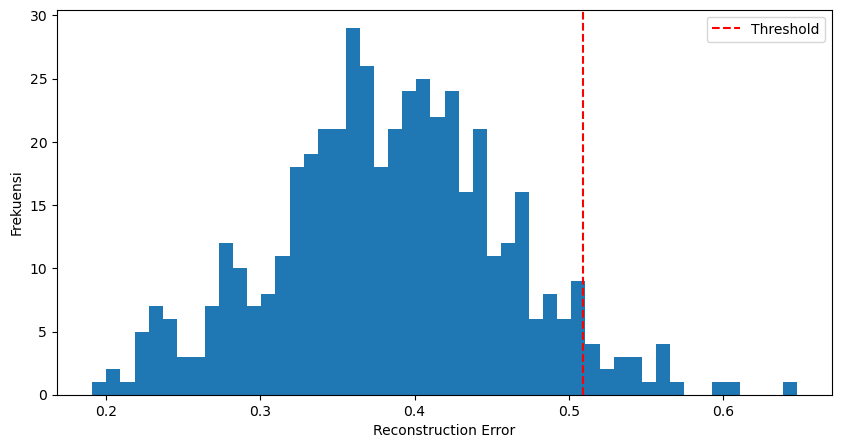

Jumlah anomali terdeteksi: 24


In [59]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("yaskawa_train.csv")  # Ganti dengan path dataset yang sesuai

# Pilih fitur yang akan digunakan (tanpa kolom yang selalu konstan)
features = [
    "Frequency Reference", "Output Frequency", "Output Current",
    "Output Power", "Output Voltage", "Fin Temperature",
    "Cooling Fin Temperature", "Cooling Fan Operation Time"
]

X = df[features].values

# Normalisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Bentuk ulang untuk LSTM (samples, timesteps, features)
sequence_length = 20  # Misalnya, gunakan 20 data berturut-turut sebagai satu sekuens
X_sequences = []
for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i : i + sequence_length])

X_sequences = np.array(X_sequences)

# Bagi data menjadi training dan testing
X_train, X_test = train_test_split(X_sequences, test_size=0.2, random_state=42)

# Model LSTM Autoencoder
timesteps = X_train.shape[1]
features = X_train.shape[2]

input_layer = Input(shape=(timesteps, features))
encoded = LSTM(64, activation="relu", return_sequences=True)(input_layer)
encoded = LSTM(32, activation="relu", return_sequences=False)(encoded)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(32, activation="relu", return_sequences=True)(decoded)
decoded = LSTM(64, activation="relu", return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(features))(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

# Train model
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_test, X_test), verbose=1)

# Rekonstruksi data
X_test_pred = autoencoder.predict(X_test)

# Hitung error rekonstruksi (MSE)
reconstruction_error = np.mean(np.abs(X_test_pred - X_test), axis=(1, 2))

# Tentukan threshold anomali (misalnya, persentil 95 dari error)
threshold = np.percentile(reconstruction_error, 95)

# Tandai anomali jika error lebih besar dari threshold
anomalies = reconstruction_error > threshold

# Plot error rekonstruksi
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_error, bins=50)
plt.axvline(threshold, color="r", linestyle="dashed", label="Threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frekuensi")
plt.legend()
plt.show()

print(f"Jumlah anomali terdeteksi: {np.sum(anomalies)}")


Epoch 1/400


c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 567074.9375 - mae: 651.1351 - val_loss: 94838.7891 - val_mae: 235.0266
Epoch 2/400
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 111924.2109 - mae: 261.8125 - val_loss: 62053.2734 - val_mae: 203.5221
Epoch 3/400
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 67935.3047 - mae: 203.7307 - val_loss: 56627.8398 - val_mae: 193.2838
Epoch 4/400
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 63337.9258 - mae: 197.2178 - val_loss: 54498.2148 - val_mae: 189.3904
Epoch 5/400
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 58977.7188 - mae: 192.6043 - val_loss: 40093.3672 - val_mae: 166.3257
Epoch 6/400
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 51762.6250 - mae: 182.1452 - val_loss: 55532.9336 - val_mae: 190.6820
Epoch 7/400
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 55659.9570 - mae: 187.1202 - val_loss: 38435.3125 - val_mae: 164.5990
Epoch 8/400
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 53046.2734 - mae: 183.5629 - val_loss: 4

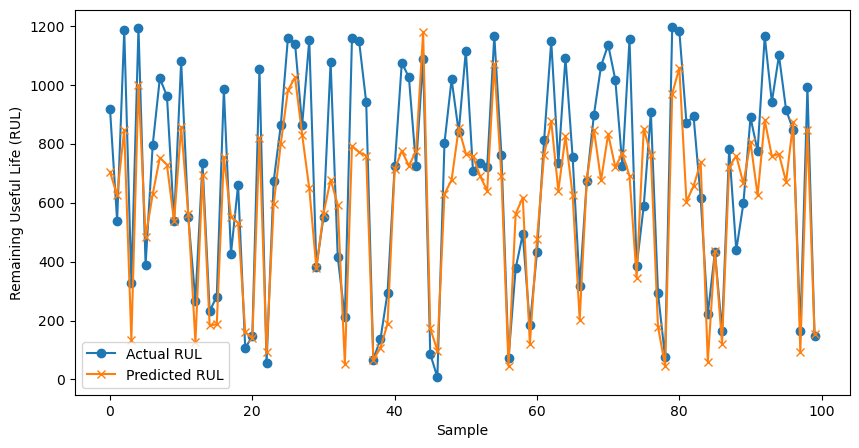

In [60]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1️⃣ Load dataset
df = pd.read_csv("yaskawa_train.csv")  # Sesuaikan dengan file Anda

# Konversi waktu ke dalam format waktu seconds
df['Time'] = pd.to_timedelta(df['Time'])
df['Time'] = df['Time'].dt.total_seconds()
df.sort_index()

# 2️⃣ Hitung RUL sebagai (maksimal waktu - waktu sekarang)
df["RUL"] = df["Time"].max() - df["Time"]

# 3️⃣ Pilih fitur yang relevan untuk training
features = [
    "Frequency Reference", "Output Frequency", "Output Current",
    "Output Power", "Output Voltage", "Fin Temperature",
    "Cooling Fin Temperature", "Cooling Fan Operation Time"
]
target = "RUL"

X = df[features].values
y = df[target].values

# 4️⃣ Normalisasi fitur agar model lebih stabil
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5️⃣ Konversi data ke bentuk sekuensial untuk LSTM
sequence_length = 30  # Gunakan 30 langkah waktu per sequence
X_sequences, y_sequences = [], []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i : i + sequence_length])
    y_sequences.append(y[i + sequence_length])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# 6️⃣ Split data untuk training & testing
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

# 7️⃣ Bangun model LSTM
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Output adalah nilai RUL
])

# 8️⃣ Compile model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# 9️⃣ Train model
history = model.fit(X_train, y_train, epochs=400, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# 🔟 Evaluasi model
loss, mae = model.evaluate(X_test, y_test)
print(f"Mean Absolute Error (MAE): {mae}")

# 🔢 Prediksi RUL pada data uji
y_pred = model.predict(X_test)

# 📊 Visualisasi hasil prediksi vs nilai aktual
plt.figure(figsize=(10, 5))
plt.plot(y_test[:100], label="Actual RUL", marker='o')
plt.plot(y_pred[:100], label="Predicted RUL", marker='x')
plt.xlabel("Sample")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.show()


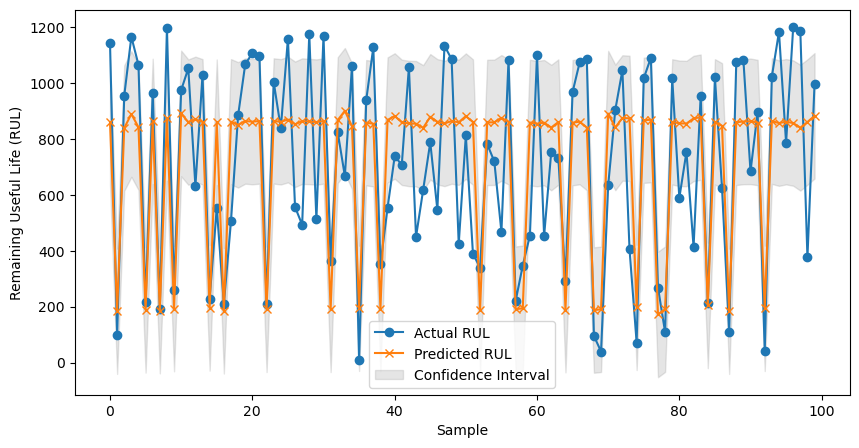

In [61]:
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1️⃣ Load dataset
df = pd.read_csv("yaskawa_train.csv")  

# Konversi waktu ke dalam format waktu seconds
df['Time'] = pd.to_timedelta(df['Time'])
df['Time'] = df['Time'].dt.total_seconds()
df.sort_index()

# 2️⃣ Hitung RUL
df["RUL"] = df["Time"].max() - df["Time"]

# 3️⃣ Pilih fitur
features = [
    "Frequency Reference", "Output Frequency", "Output Current",
    "Output Power", "Output Voltage", "Fin Temperature",
    "Cooling Fin Temperature", "Cooling Fan Operation Time"
]
target = "RUL"

X = df[features].values
y = df[target].values

# 4️⃣ Normalisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5️⃣ Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 6️⃣ Bangun model Bayesian Ridge Regression
bayesian_model = BayesianRidge()
bayesian_model.fit(X_train, y_train)

# 🔢 Prediksi
y_pred, y_std = bayesian_model.predict(X_test, return_std=True)

# 📊 Visualisasi dengan Ketidakpastian
plt.figure(figsize=(10, 5))
plt.plot(y_test[:100], label="Actual RUL", marker='o')
plt.plot(y_pred[:100], label="Predicted RUL", marker='x')
plt.fill_between(range(100), y_pred[:100] - y_std[:100], y_pred[:100] + y_std[:100], alpha=0.2, color="gray", label="Confidence Interval")
plt.xlabel("Sample")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.show()


In [62]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Load data
df = pd.read_csv("yaskawa_train.csv")  # Gantilah dengan file yang kamu punya

# Ambil fitur yang relevan
features = ["Output Current", "Output Power", "Output Voltage", "Fin Temperature"]
df = df[features]

# Hitung delta sebagai fitur tambahan
df["ΔCurrent"] = df["Output Current"].diff()
df["ΔPower"] = df["Output Power"].diff()
df["ΔTemperature"] = df["Fin Temperature"].diff()

# Hilangkan NaN akibat differencing
df = df.dropna()

# Normalisasi data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Buat dataset time-series
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Target: Output Current (bisa diganti)
    return np.array(X), np.array(y)

seq_length = 10  # Misalnya, gunakan 10 langkah waktu sebelumnya untuk prediksi
X, y = create_sequences(df_scaled, seq_length)

# Konversi ke tensor PyTorch
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Split train-test
train_size = int(0.8 * len(X))
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16, shuffle=False)

# Definisikan model LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Ambil output dari time-step terakhir
        return out

# Inisialisasi model
input_dim = len(features) + 3  # Tambahan 3 fitur delta
model = LSTMModel(input_dim, hidden_dim=64, num_layers=2, output_dim=1)

# Loss function dan optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Evaluasi model
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)
    test_loss = criterion(y_pred_test, y_test)
    print(f"Test Loss: {test_loss.item()}")


Epoch 1/50, Loss: 0.08560200780630112
Epoch 2/50, Loss: 0.06672856211662292
Epoch 3/50, Loss: 0.06484205275774002
Epoch 4/50, Loss: 0.057572636753320694
Epoch 5/50, Loss: 0.036605414003133774
Epoch 6/50, Loss: 0.06718903034925461
Epoch 7/50, Loss: 0.036273740231990814
Epoch 8/50, Loss: 0.03603782877326012
Epoch 9/50, Loss: 0.04048805683851242
Epoch 10/50, Loss: 0.047659844160079956
Epoch 11/50, Loss: 0.03557639196515083
Epoch 12/50, Loss: 0.06761365383863449
Epoch 13/50, Loss: 0.0536176860332489
Epoch 14/50, Loss: 0.0603378601372242
Epoch 15/50, Loss: 0.09257551282644272
Epoch 16/50, Loss: 0.10441906005144119
Epoch 17/50, Loss: 0.05635780841112137
Epoch 18/50, Loss: 0.02854374423623085
Epoch 19/50, Loss: 0.04372158646583557
Epoch 20/50, Loss: 0.018835021182894707
Epoch 21/50, Loss: 0.033990759402513504
Epoch 22/50, Loss: 0.02378981001675129
Epoch 23/50, Loss: 0.0928424596786499
Epoch 24/50, Loss: 0.037773508578538895
Epoch 25/50, Loss: 0.03406073525547981
Epoch 26/50, Loss: 0.018685180

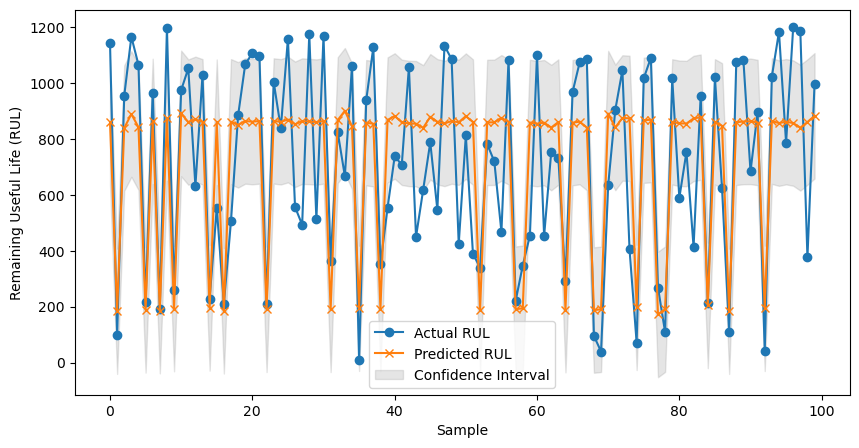

In [63]:
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1️⃣ Load dataset
df = pd.read_csv("yaskawa_train.csv")  

# Konversi waktu ke dalam format waktu seconds
df['Time'] = pd.to_timedelta(df['Time'])
df['Time'] = df['Time'].dt.total_seconds()
df.sort_index()

# 2️⃣ Hitung RUL
df["RUL"] = df["Time"].max() - df["Time"]

# 3️⃣ Pilih fitur
features = [
    "Frequency Reference", "Output Frequency", "Output Current",
    "Output Power", "Output Voltage", "Fin Temperature",
    "Cooling Fin Temperature", "Cooling Fan Operation Time"
]
target = "RUL"

X = df[features].values
y = df[target].values

# 4️⃣ Normalisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5️⃣ Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 6️⃣ Bangun model Bayesian Ridge Regression
bayesian_model = BayesianRidge()
bayesian_model.fit(X_train, y_train)

# 🔢 Prediksi
y_pred, y_std = bayesian_model.predict(X_test, return_std=True)

# 📊 Visualisasi dengan Ketidakpastian
plt.figure(figsize=(10, 5))
plt.plot(y_test[:100], label="Actual RUL", marker='o')
plt.plot(y_pred[:100], label="Predicted RUL", marker='x')
plt.fill_between(range(100), y_pred[:100] - y_std[:100], y_pred[:100] + y_std[:100], alpha=0.2, color="gray", label="Confidence Interval")
plt.xlabel("Sample")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.show()
